# Guided Training
- Die letzten beiden Zellen benoetigen ein SimpleElastix-Setup
## Genereller Ablauf:
- Die canonical-VISCERAL Daten werden geladen und einige Hilfsfunktionen fuer das Erstellen der Laplace-(Block-)Matrizen werden definiert.
- Momentan werden bei den Paaren die MR-Bilder als fixed und die CT-Daten als moving angenommen.
- Der LaplaceMultiGrid-Schritt wird fuer die 3 Dimensionen gekoppelt aufgebaut, d.h. mit insgesamt dann 9 Block-Diagonalen im LGS.
- Fuer das guided-Training werden die Segmentierungslabel herangezogen und fuer eine zufaellige (< reg_iter) Anzahl an Schritten das "guided-grid" zurueckgegeben mittels der Funktion "perform_guided_update", welche ebenfalls die Signed Distance Maps (tanh-clipping auf [0,1]) der Fixed-One-Hot und Guided-Warped-Moving-One-Hot liefert. 
- Waehrend des Trainings wird pro Durchgang ein Bildpaar gezogen, einer zufaelligen Anzahl an guided_update Schritten unterzogen und anschließend wird von dort aus mit GradientTracking ein Update-Schritt fuer das displacement-grid berechnet. Je nach Art des Losses, wird das One-Hot-Warped-Mov-Image dieser aktualisierten Transformation unterworfen und mit dem One-Hot-Fixed-Image verglichen oder die jeweiligen Signed-Distance-Transformationen.
- Als Netz wird momentan die angedachte Y-Struktur genutzt, d.h. fix_net/mov_net werden getrennt pro Modalität genutzt und dann anschliessend noch durch das shared-weight "back_net" gefuehrt.
- Das direkte Einbeziehen von MIND-Features als Eingabe im Netz vor lernbaren Layern hat leider ebenso wenig stabile Ergebnisse gebracht bisher, wie das Training von Scratch.
- Der Sinn der einzelnen Zellen wird im Folgenden nochmal detaillierter kommentiert.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import torch.nn.functional as F
import warnings
#warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

flag_all = True

In [2]:
# two Laplace matrix generating functions: 
# the first one is used on the right hand side of the LGS to compute the
# term that is dependend on the previous grid-step (e.g.: - L*u_kminus1)
# the second one generates block-sparse Laplace matrices that will be used during the construction of the 
# LSE lefthand side 

def laplace(lambda_weight,D,H,W):
    # e.g. 3x3: 
    # 0 1 2    -> to get "down" neighbors: take xy[1:,:]  -> 3 4 5 and xy[:-1,:] -> 0 1 2      
    # 3 4 5                                                  6 7 8                  3 4 5
    # 6 7 8
    # i.e.: get index pairs: 3 4 5 6 7 8  
    #                        0 1 2 3 4 5
    # do the same for "up", "left" and "right" neighbors
    xyz = torch.arange(D*H*W).view(D,H,W)
    i1 = torch.cat((xyz[1:,:,:].reshape(1,-1),xyz[:-1,:,:].reshape(1,-1)),0)
    i2 = torch.cat((xyz[:-1,:,:].reshape(1,-1),xyz[1:,:,:].reshape(1,-1)),0)
    i3 = torch.cat((xyz[:,1:,:].reshape(1,-1),xyz[:,:-1,:].reshape(1,-1)),0)
    i4 = torch.cat((xyz[:,:-1,:].reshape(1,-1),xyz[:,1:,:].reshape(1,-1)),0)
    i5 = torch.cat((xyz[:,:,1:].reshape(1,-1),xyz[:,:,:-1].reshape(1,-1)),0)
    i6 = torch.cat((xyz[:,:,:-1].reshape(1,-1),xyz[:,:,1:].reshape(1,-1)),0)
    
    sparse_idx_positions = torch.cat((i1,i2,i3,i4,i5,i6),1)
    
    # now fill a sparse matrix at these indices with -1 * lambda
    A = lambda_weight * torch.sparse.FloatTensor(sparse_idx_positions, # indices 
                                                 -torch.ones(sparse_idx_positions.size(1)), # values to fill in 
                                                 torch.Size([H*W*D,H*W*D])) # output shape
    Di = torch.spmm(A,-torch.ones(H*W*D,1)).view(-1) # compute column sum to add at main diagonal
    Di = torch.sparse.FloatTensor(torch.stack((torch.arange(H*W*D),torch.arange(H*W*D)),0), 
                                  Di, 
                                  torch.Size([H*W*D,H*W*D]))
    L = (Di + A)#.to_dense() 
    return L


def laplace_block(lambda_weight,D,H,W,position):
    # e.g. 3x3: 
    # 0 1 2    -> to get "down" neighbors: take xy[1:,:]  -> 3 4 5 and xy[:-1,:] -> 0 1 2      
    # 3 4 5                                                  6 7 8                  3 4 5
    # 6 7 8
    # i.e.: get index pairs: 3 4 5 6 7 8  
    #                        0 1 2 3 4 5
    # do the same for "up", "left" and "right" neighbors
    xyz = torch.arange(D*H*W).view(D,H,W)
    i1 = torch.cat((xyz[1:,:,:].reshape(1,-1),xyz[:-1,:,:].reshape(1,-1)),0)
    i2 = torch.cat((xyz[:-1,:,:].reshape(1,-1),xyz[1:,:,:].reshape(1,-1)),0)
    i3 = torch.cat((xyz[:,1:,:].reshape(1,-1),xyz[:,:-1,:].reshape(1,-1)),0)
    i4 = torch.cat((xyz[:,:-1,:].reshape(1,-1),xyz[:,1:,:].reshape(1,-1)),0)
    i5 = torch.cat((xyz[:,:,1:].reshape(1,-1),xyz[:,:,:-1].reshape(1,-1)),0)
    i6 = torch.cat((xyz[:,:,:-1].reshape(1,-1),xyz[:,:,1:].reshape(1,-1)),0)
    
    sparse_idx_positions = torch.cat((i1,i2,i3,i4,i5,i6),1)
    
    if 'u' == position:
        # upper left
        # now fill a sparse matrix at these indices with -1 * lambda
        A = lambda_weight * torch.sparse.FloatTensor(sparse_idx_positions, # indices 
                                                     -torch.ones(sparse_idx_positions.size(1)), # values to fill in 
                                                     torch.Size([3*H*W*D,3*H*W*D])) # output shape
        Di = torch.spmm(A,-torch.ones(3*H*W*D,1)).view(-1) # compute column sum to add at main diagonal
        Di = torch.sparse.FloatTensor(torch.stack((torch.arange(3*H*W*D),torch.arange(3*H*W*D)),0), 
                                      Di, 
                                      torch.Size([3*H*W*D,3*H*W*D]))
        L = (Di + A)#.to_dense() 
        return L
    
    if 'm' == position:
        # middle
        # now fill a sparse matrix at these indices with -1 * lambda
        A = lambda_weight * torch.sparse.FloatTensor(sparse_idx_positions + (H*W*D), # indices 
                                                     -torch.ones(sparse_idx_positions.size(1)), # values to fill in 
                                                     torch.Size([3*H*W*D,3*H*W*D])) # output shape
        Di = torch.spmm(A,-torch.ones(3*H*W*D,1)).view(-1) # compute column sum to add at main diagonal
        Di = torch.sparse.FloatTensor(torch.stack((torch.arange(3*H*W*D),torch.arange(3*H*W*D)),0), 
                                      Di, 
                                      torch.Size([3*H*W*D,3*H*W*D]))
        L = (Di + A)#.to_dense() 
        return L
    
    if 'l' == position:
        # lower right
        # now fill a sparse matrix at these indices with -1 * lambda
        A = lambda_weight * torch.sparse.FloatTensor(sparse_idx_positions + (2*H*W*D), # indices 
                                                     -torch.ones(sparse_idx_positions.size(1)), # values to fill in 
                                                     torch.Size([3*H*W*D,3*H*W*D])) # output shape
        Di = torch.spmm(A,-torch.ones(3*H*W*D,1)).view(-1) # compute column sum to add at main diagonal
        Di = torch.sparse.FloatTensor(torch.stack((torch.arange(3*H*W*D),torch.arange(3*H*W*D)),0), 
                                      Di, 
                                      torch.Size([3*H*W*D,3*H*W*D]))
        L = (Di + A)#.to_dense() 
        return L

In [3]:
# this function is used to load & preprocess a CT-MR-image pair

def get_ct_mr_pair(ct_idx, mr_idx, scale_factor):
    
    ct_base_path = '/share/data_sam1/blendowski/no_backup/tmp/imagedata/VISCERAL_canonical/'
    mr_base_path = '/share/data_sam1/blendowski/no_backup/tmp/imagedata/VISCERAL_canonical/'

    # fix MR, mov CT
    ct_pat = ct_idx.__str__()
    mr_pat = mr_idx.__str__()

    print('CT Pat: ', ct_pat, ' :: MR Pat: ', mr_pat)
    img_mov = nib.load(ct_base_path+'ct'+ct_pat+'_img.nii.gz').get_data()
    img_mov = torch.from_numpy(img_mov).float().unsqueeze(0).unsqueeze(0)

    seg_mov = nib.load(ct_base_path+'ct'+ct_pat+'_seg.nii.gz').get_data()
    seg_mov = torch.from_numpy(seg_mov).float().unsqueeze(0).unsqueeze(0)

    img_fix = nib.load(ct_base_path+'mr'+mr_pat+'_img.nii.gz').get_data()
    img_fix = torch.from_numpy(img_fix).float().unsqueeze(0).unsqueeze(0)

    seg_fix = nib.load(ct_base_path+'mr'+mr_pat+'_seg.nii.gz').get_data()
    seg_fix = torch.from_numpy(seg_fix).float().unsqueeze(0).unsqueeze(0)

    _,_,D_,H_,W_ = img_mov.size()




    sc_val = scale_factor
    sc_size = (int(sc_val*D_),int(sc_val*H_),int(sc_val*W_))

    #print('Original Size: ',D_,H_,W_)
    #print('Rescaled Size: ',sc_size, ' factor: ', sc_val.__str__())
    #print('Dice base:' ,dice_coeff(seg_mov,seg_fix,max_label=8),dice_coeff(seg_mov,seg_fix,max_label=8).mean())

    img_mov = torch.nn.functional.interpolate(img_mov,size=sc_size)
    seg_mov = torch.nn.functional.interpolate(seg_mov,size=sc_size,mode='nearest')
    img_fix = torch.nn.functional.interpolate(img_fix,size=sc_size)
    seg_fix = torch.nn.functional.interpolate(seg_fix,size=sc_size,mode='nearest')

    # preprocess with a zero-mean 1-std-dev trafo below?
    
    img_mov -= img_mov.mean()
    img_mov /= img_mov.std()
    img_mov /= torch.abs(img_mov).max()
    img_fix -= img_fix.mean()
    img_fix /= img_fix.std()
    img_fix /= torch.abs(img_fix).max()

    return img_fix, seg_fix, img_mov, seg_mov

In [4]:
# build derivatives: these will be employed during the building of the LSE  

def d_dW(img_in): # D
    b,c,d,h,w = img_in.size()
    kernel = torch.zeros(c,1,3,3,3)
    kernel[:,0,1,1,0] = -0.5
    kernel[:,0,1,1,2] = +0.5
    kernel = kernel.to(img_in.device)
    out = torch.nn.functional.conv3d(img_in, kernel, bias=None, stride=1, padding=0, dilation=1, groups=c)
    out = torch.nn.functional.pad(out,(1,1,1,1,1,1),mode='replicate')
    return out


def d_dH(img_in):
    b,c,d,h,w = img_in.size()
    kernel = torch.zeros(c,1,3,3,3)
    kernel[:,0,1,0,1] = -0.5
    kernel[:,0,1,2,1] = +0.5
    kernel = kernel.to(img_in.device)
    out = torch.nn.functional.conv3d(img_in, kernel, bias=None, stride=1, padding=0, dilation=1, groups=c)
    out = torch.nn.functional.pad(out,(1,1,1,1,1,1),mode='replicate')
    return out

def d_dD(img_in): # W
    b,c,d,h,w = img_in.size()
    kernel = torch.zeros(c,1,3,3,3)
    kernel[:,0,0,1,1] = -0.5
    kernel[:,0,2,1,1] = +0.5
    kernel = kernel.to(img_in.device)
    out = torch.nn.functional.conv3d(img_in, kernel, bias=None, stride=1, padding=0, dilation=1, groups=c)
    out = torch.nn.functional.pad(out,(1,1,1,1,1,1),mode='replicate')
    return out

In [5]:
# differentiable solver to propagate the gradient towards the difference-image representations on the RHS of the LSE
from scipy.sparse import csr_matrix
import pyamg

class MySparseSolverFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, A,b,iters):
        
        A_ind = A._indices().cpu().data.numpy()
        A_val = A._values().cpu().data.numpy()
        n1,n2 = A.size()
        SC = csr_matrix((A_val,(A_ind[0,:],A_ind[1,:])), shape=(n1,n2))
        ml = pyamg.ruge_stuben_solver(SC,max_levels=10)                    # construct the multigrid hierarchy
        #print(ml)                                                        # print hierarchy information
        b_ = b.cpu().data.numpy()
        x = ml.solve(b_, tol=1e-4)
        x = torch.from_numpy(x).view(-1,1).to(b.device)
        # save all tensors for backward step
        ctx.save_for_backward(A,b,x)
        
        return x

    @staticmethod
    def backward(ctx, grad_output):
        A,b,x = ctx.saved_tensors
        A_ind = A._indices().cpu().data.numpy()
        A_val = A._values().cpu().data.numpy()
        n1,n2 = A.size()
        
        grad_output_ = grad_output.cpu().data.numpy()
        SC_A_transposed = csr_matrix((A_val,(A_ind[1,:],A_ind[0,:])), shape=(n2,n1))
        ml = pyamg.ruge_stuben_solver(SC_A_transposed,max_levels=10)
        grad_b = ml.solve(grad_output_, tol=1e-4)
        grad_b = torch.from_numpy(grad_b).view(-1,1).to(x.device)
        
        A_back_val = (-grad_b[A_ind[0,:]]*x[A_ind[1,:]]).squeeze().to(x.device)
        A_back = torch.sparse.FloatTensor(A._indices(), A_back_val, A.size()).to(x.device)
        return A_back, grad_b, None
    
def mlg_solver(A,b,iters):
    return MySparseSolverFunction.apply(A,b,iters)

In [6]:
def dice_coeff(outputs, labels, max_label):
    """
    Evaluation function for Dice score of segmentation overlap
    """
    dice = torch.FloatTensor(max_label-1).fill_(0).to(outputs.device)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = (iflat * tflat).sum()
        dice[label_num-1] = (2. * intersection) / (iflat.sum() + tflat.sum())
    return dice

def countParameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

#hand-crafted MIND-SSC features
def MINDSSC3d(img,dil=3,patch_rad=3):

    kernel = patch_rad*2+1
    #define start-end locations for self-similarity pattern
    six_neighbour = torch.Tensor([[0,1,1],[1,1,0],[1,0,1],[1,1,2],[2,1,1],[1,2,1]])
    pdist = ((six_neighbour.unsqueeze(1)-six_neighbour.unsqueeze(0))**2).sum(2)
    x,y = torch.meshgrid(torch.arange(6),torch.arange(6))
    mask = ((x>y).view(-1))&(pdist.view(-1)==2)
    idx_shift1 = six_neighbour.long().unsqueeze(1).repeat(1,6,1).view(-1,3)[mask,:]
    idx_shift2 = six_neighbour.long().unsqueeze(0).repeat(6,1,1).view(-1,3)[mask,:]
    mshift1 = torch.zeros(12,1,3,3,3).to(img.device).type(img.dtype)
    mshift1.view(-1)[torch.arange(12)*27+idx_shift1[:,0]*9+idx_shift1[:,1]*3+idx_shift1[:,2]] = 1
    mshift2 = torch.zeros(12,1,3,3,3).to(img.device).type(img.dtype)
    mshift2.view(-1)[torch.arange(12)*27+idx_shift2[:,0]*9+idx_shift2[:,1]*3+idx_shift2[:,2]] = 1
    rpad1 = torch.nn.ReplicationPad3d(dil)
    rpad2 = torch.nn.ReplicationPad3d(patch_rad)
    #compute patch-ssd
    ssd = F.avg_pool3d(rpad2((F.conv3d(rpad1(img),mshift1,dilation=dil)-F.conv3d(rpad1(img),mshift2,dilation=dil))**2),kernel,stride=1)
    #MIND equation
    mind = ssd - torch.min(ssd,1,keepdim=True)[0]
    mind_var = torch.mean(mind,1,keepdim=True)
    mind_var = torch.clamp(mind_var,mind_var.mean()*0.001,mind_var.mean()*1000)
    mind /= mind_var
    mind = torch.exp(-mind)
    #permute to have same ordering as C++ code
    mind = mind[:,torch.Tensor([6,8,1,11,2,10,0,7,9,4,5,3]).long(),:,:,:]
    
    return mind

In [7]:
# PREPARE training and test data splits

with torch.no_grad():
    torch.manual_seed(1909)
    ct_patients = torch.arange(1,21)
    mr_patients = torch.arange(1,21)#cat((torch.arange(1,3),torch.arange(4,20)),0)
    
    total_pat_sz = 20
    train_sz = 14
    test_sz = total_pat_sz - train_sz
    
    rnd_perm = torch.randperm(20)
    ct_train_pats = (ct_patients[rnd_perm])[:train_sz]
    ct_test_pats = (ct_patients[rnd_perm])[train_sz:]
    rnd_perm = torch.randperm(20)
    mr_train_pats = (mr_patients[rnd_perm])[:train_sz]
    mr_test_pats = (mr_patients[rnd_perm])[train_sz:]
    
    print('CT Train: ',ct_train_pats)
    print('CT Test:  ',ct_test_pats)
    print('MR Train: ',mr_train_pats)
    print('MR Test:  ',mr_test_pats)
    
    img_fix, seg_fix, img_mov, seg_mov = get_ct_mr_pair(ct_train_pats[0].item(), mr_train_pats[0].item(), 0.70)
        
    B,C,D,H,W = img_fix.size()

    

CT Train:  tensor([ 9,  8,  1,  5, 14,  7, 20,  4, 16, 11, 18, 15, 10,  6])
CT Test:   tensor([ 2, 19, 13,  3, 17, 12])
MR Train:  tensor([17, 13,  5,  3,  8, 18,  4,  2,  7,  9, 16, 10, 20, 11])
MR Test:   tensor([15, 14,  1,  6, 12, 19])
CT Pat:  9  :: MR Pat:  17


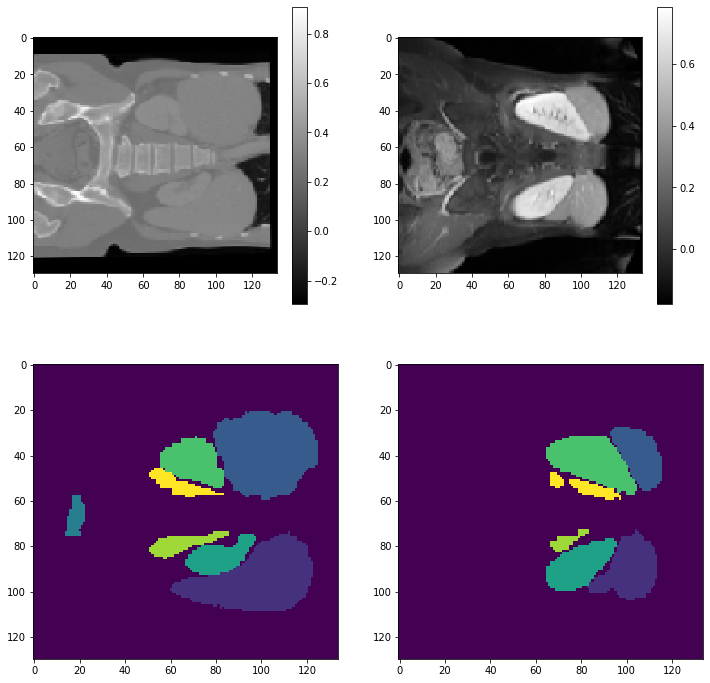

In [8]:
# visualize the first volumes of the training data set
plt.figure(figsize=(12,12))
plt_sl = 35
plt.subplot(221)
plt.imshow(img_mov[0,0,:,plt_sl,:].detach().squeeze(),'gray')
plt.colorbar()
plt.subplot(223)
plt.imshow(seg_mov[0,0,:,plt_sl,:].detach().squeeze())
plt.subplot(222)
plt.imshow(img_fix[0,0,:,plt_sl,:].detach().squeeze(),'gray')
plt.colorbar()
plt.subplot(224)
plt.imshow(seg_fix[0,0,:,plt_sl,:].detach().squeeze())

In [9]:
class MixNet(torch.nn.Module):
    def __init__(self):
        super(MixNet, self).__init__()
        self.c0 = torch.nn.Conv3d(1,16,5,dilation=2,padding=4,stride=1)
        self.c1 = torch.nn.Conv3d(32,32,3,dilation=1,padding=1,stride=2)
        self.c2 = torch.nn.Conv3d(32,32,3,dilation=1,padding=1,stride=1)
        self.c3 = torch.nn.Conv3d(32,12,3,dilation=1,padding=1,stride=1)
        self.n0 = torch.nn.InstanceNorm3d(16)
        self.n1 = torch.nn.InstanceNorm3d(32)
        self.n2 = torch.nn.InstanceNorm3d(32)
        
        self.acti = torch.nn.ReLU()
        self.acti_out = torch.nn.Sigmoid()
        
        self.c0_ct = torch.nn.Conv3d(1,16,5,dilation=2,padding=4,stride=1)
        self.c1_ct = torch.nn.Conv3d(16,32,3,dilation=1,padding=1,stride=1)
        self.c2_ct = torch.nn.Conv3d(32,32,3,dilation=1,padding=1,stride=1)
        self.ct_n0 = torch.nn.InstanceNorm3d(16)
        self.ct_n1 = torch.nn.InstanceNorm3d(32)
        self.ct_n2 = torch.nn.InstanceNorm3d(32)
        
        self.c0_mr = torch.nn.Conv3d(1,16,5,dilation=2,padding=4,stride=1)
        self.c1_mr = torch.nn.Conv3d(16,32,3,dilation=1,padding=1,stride=1)
        self.c2_mr = torch.nn.Conv3d(32,32,3,dilation=1,padding=1,stride=1)
        self.mr_n0 = torch.nn.InstanceNorm3d(16)
        self.mr_n1 = torch.nn.InstanceNorm3d(32)
        self.mr_n2 = torch.nn.InstanceNorm3d(32)
        
        
    def forward(self, x, modality):
        if modality == 'ct':
            x0 = self.acti(self.ct_n0(self.c0_ct(x)))
            x1_s = self.acti(self.ct_n1(self.c1_ct(x0)))
            #x2 = self.acti(self.ct_n2(self.c2_ct(x1)))
            #out = self.acti_out(self.c3(x2))
            #return out
        if modality == 'mr':
            x0 = self.acti(self.mr_n0(self.c0_mr(x)))
            x1_s = self.acti(self.mr_n1(self.c1_mr(x0)))
            #x2 = self.acti(self.mr_n2(self.c2_mr(x1)))
            #out = self.acti_out(self.c3(x2))
            #return out
        x1 = self.acti(self.n1(self.c1(x1_s)))
        x2 = self.acti(self.n2(self.c2(x1)))
        out = self.acti_out(self.c3(x2))
        return out

In [10]:
# this function takes two segmentation images. since these images act as guidance during the training,
# informed update steps will be computed using the LaplaceMultiGrid-approach. The update-grid as well as 
# signed distance transformed image representations of the fixed and the warped moving segmentation are returned

from scipy.ndimage.morphology import distance_transform_edt as EDT

def perform_guided_updates(lab_mov, lab_fix, reg_iters):
    # due to time & space issues during the LSE solving, the images will be downsampled by a factor of 0.5 per dimension
    # all _pgu appendices are only to seperate the namespaces, i.e. we are able to delete these variables and free
    # gpu memory after calling this pgu-function
    
    sc_val_pgu = 0.5
    
    lambda_reg_pgu = 2.5#25
    solver_iter_pgu = 3
    C_out_pgu = 8 # label-number!
    dice_evo_pgu = torch.zeros(reg_iters,7)
    # get image sizes to allocate the variables of corresponding sizes
    _,_,Ds_pgu,Hs_pgu,Ws_pgu = torch.nn.functional.interpolate(lab_mov,scale_factor=sc_val_pgu,mode='nearest').size()
    _,_,D_pgu,H_pgu,W_pgu = lab_mov.size()
    # prepare the laplace matrix for the right hand side
    L_pgu = laplace(lambda_reg_pgu,Ds_pgu,Hs_pgu,Ws_pgu).cuda()
    # prepare the left hand side laplace block matrices
    L_u_pgu = laplace_block(lambda_reg_pgu,Ds_pgu,Hs_pgu,Ws_pgu,'u').cuda()
    L_m_pgu = laplace_block(lambda_reg_pgu,Ds_pgu,Hs_pgu,Ws_pgu,'m').cuda()
    L_l_pgu = laplace_block(lambda_reg_pgu,Ds_pgu,Hs_pgu,Ws_pgu,'l').cuda()
    
    # initialize the grid-update accumulation vectors ("km1 -> k_minus_1") with zeros
    u_km1_pgu = torch.zeros(Ds_pgu*Hs_pgu*Ws_pgu).view(-1,1).cuda()
    v_km1_pgu = torch.zeros(Ds_pgu*Hs_pgu*Ws_pgu).view(-1,1).cuda()
    w_km1_pgu = torch.zeros(Ds_pgu*Hs_pgu*Ws_pgu).view(-1,1).cuda()

    id_grid_pgu = torch.nn.functional.affine_grid(torch.eye(3,4).view(1,3,4),(1,1,D_pgu,H_pgu,W_pgu)).cuda()

    avg3d = torch.nn.AvgPool3d(kernel_size=5,padding=2,stride=1)
    
    lab_mov_hot_pgu = torch.nn.functional.one_hot(lab_mov.long(),num_classes=8).squeeze().permute(3,0,1,2).unsqueeze(0).float()
    lab_fix_hot_pgu = torch.nn.functional.one_hot(lab_fix.long(),num_classes=8).squeeze().permute(3,0,1,2).unsqueeze(0).float()


    for idx in range(reg_iters):

        # upscale displacement fields: since the update stop solution is computed on a downsampled version,
        # we have to recover the original resolution by upsampling; then we warp the full size label images
        # accordingly, before solving again on the lower resolution
        with torch.no_grad():
            grid_up_km1_pgu = torch.cat((w_km1_pgu.view(1,Ds_pgu,Hs_pgu,Ws_pgu,1),v_km1_pgu.view(1,Ds_pgu,Hs_pgu,Ws_pgu,1),u_km1_pgu.view(1,Ds_pgu,Hs_pgu,Ws_pgu,1)),4)
            grid_up_km1_pgu = avg3d(grid_up_km1_pgu.permute(0,4,1,2,3))
            #grid_up_km1 = grid_up_km1.permute(0,4,1,2,3)
            grid_up_km1_pgu = torch.nn.functional.interpolate(grid_up_km1_pgu, size=(D_pgu,H_pgu,W_pgu)).permute(0,2,3,4,1)

            M_km1_pgu = torch.nn.functional.grid_sample(lab_mov_hot_pgu.view(1,8,D_pgu,H_pgu,W_pgu).cuda(), 
                                                        grid_up_km1_pgu + id_grid_pgu,
                                                        padding_mode='border',
                                                        mode='nearest')


        # subsample: compute the update steps on the lower resolution
        M_km1_pgu = torch.nn.functional.interpolate(M_km1_pgu,scale_factor=sc_val_pgu,mode='nearest').cuda()
        fix_pgu = torch.nn.functional.interpolate(lab_fix_hot_pgu,scale_factor=sc_val_pgu,mode='nearest').cuda()
        # compute the derivative images
        M_km1_dD_pgu = d_dD(M_km1_pgu)
        M_km1_dH_pgu = d_dH(M_km1_pgu)
        M_km1_dW_pgu = d_dW(M_km1_pgu)

        # build the LSE
        RHS_D_pgu = -((M_km1_pgu-fix_pgu).view(C_out_pgu,Ds_pgu*Hs_pgu*Ws_pgu,1)*M_km1_dD_pgu.view(C_out_pgu,Ds_pgu*Hs_pgu*Ws_pgu,1)).sum(0) - torch.spmm(L_pgu,u_km1_pgu.view(Ds_pgu*Hs_pgu*Ws_pgu,1))
        RHS_H_pgu = -((M_km1_pgu-fix_pgu).view(C_out_pgu,Ds_pgu*Hs_pgu*Ws_pgu,1)*M_km1_dH_pgu.view(C_out_pgu,Ds_pgu*Hs_pgu*Ws_pgu,1)).sum(0) - torch.spmm(L_pgu,v_km1_pgu.view(Ds_pgu*Hs_pgu*Ws_pgu,1))
        RHS_W_pgu = -((M_km1_pgu-fix_pgu).view(C_out_pgu,Ds_pgu*Hs_pgu*Ws_pgu,1)*M_km1_dW_pgu.view(C_out_pgu,Ds_pgu*Hs_pgu*Ws_pgu,1)).sum(0) - torch.spmm(L_pgu,w_km1_pgu.view(Ds_pgu*Hs_pgu*Ws_pgu,1))

        MAT_pgu = torch.sparse.FloatTensor(3*Ds_pgu*Hs_pgu*Ws_pgu,3*Ds_pgu*Hs_pgu*Ws_pgu).cuda()
            
        M1_DD_pgu = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds_pgu*Hs_pgu*Ws_pgu),torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)),0).cuda(),
                                             (M_km1_dD_pgu**2).sum(1).view(-1),
                                             torch.Size([3*Ds_pgu*Hs_pgu*Ws_pgu,3*Ds_pgu*Hs_pgu*Ws_pgu])).detach()
        M1_DH_pgu = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds_pgu*Hs_pgu*Ws_pgu),torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)+(Ds_pgu*Hs_pgu*Ws_pgu)),0).cuda(),
                                             (M_km1_dD_pgu*M_km1_dH_pgu).sum(1).view(-1),
                                             torch.Size([3*Ds_pgu*Hs_pgu*Ws_pgu,3*Ds_pgu*Hs_pgu*Ws_pgu])).detach()
        M1_DW_pgu = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds_pgu*Hs_pgu*Ws_pgu),torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)+2*(Ds_pgu*Hs_pgu*Ws_pgu)),0).cuda(),
                                             (M_km1_dD_pgu*M_km1_dW_pgu).sum(1).view(-1),
                                             torch.Size([3*Ds_pgu*Hs_pgu*Ws_pgu,3*Ds_pgu*Hs_pgu*Ws_pgu])).detach()

        M1_HH_pgu = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)+(Ds_pgu*Hs_pgu*Ws_pgu),torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)+(Ds_pgu*Hs_pgu*Ws_pgu)),0).cuda(),
                                             (M_km1_dH_pgu**2).sum(1).view(-1),
                                             torch.Size([3*Ds_pgu*Hs_pgu*Ws_pgu,3*Ds_pgu*Hs_pgu*Ws_pgu])).detach()
        M1_HD_pgu = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)+(Ds_pgu*Hs_pgu*Ws_pgu),torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)),0).cuda(),
                                             (M_km1_dH_pgu*M_km1_dD_pgu).sum(1).view(-1),
                                             torch.Size([3*Ds_pgu*Hs_pgu*Ws_pgu,3*Ds_pgu*Hs_pgu*Ws_pgu])).detach()
        M1_HW_pgu = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)+(Ds_pgu*Hs_pgu*Ws_pgu),torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)+2*(Ds_pgu*Hs_pgu*Ws_pgu)),0).cuda(),
                                             (M_km1_dH_pgu*M_km1_dW_pgu).sum(1).view(-1),
                                             torch.Size([3*Ds_pgu*Hs_pgu*Ws_pgu,3*Ds_pgu*Hs_pgu*Ws_pgu])).detach()

        M1_WW_pgu = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)+2*(Ds_pgu*Hs_pgu*Ws_pgu),torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)+2*(Ds_pgu*Hs_pgu*Ws_pgu)),0).cuda(),
                                             (M_km1_dW_pgu**2).sum(1).view(-1),
                                             torch.Size([3*Ds_pgu*Hs_pgu*Ws_pgu,3*Ds_pgu*Hs_pgu*Ws_pgu])).detach()
        M1_WD_pgu = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)+2*(Ds_pgu*Hs_pgu*Ws_pgu),torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)),0).cuda(),
                                             (M_km1_dW_pgu*M_km1_dD_pgu).sum(1).view(-1),
                                             torch.Size([3*Ds_pgu*Hs_pgu*Ws_pgu,3*Ds_pgu*Hs_pgu*Ws_pgu])).detach()
        M1_WH_pgu = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)+2*(Ds_pgu*Hs_pgu*Ws_pgu),torch.arange(Ds_pgu*Hs_pgu*Ws_pgu)+(Ds_pgu*Hs_pgu*Ws_pgu)),0).cuda(),
                                             (M_km1_dW_pgu*M_km1_dH_pgu).sum(1).view(-1),
                                             torch.Size([3*Ds_pgu*Hs_pgu*Ws_pgu,3*Ds_pgu*Hs_pgu*Ws_pgu])).detach()


        MAT_pgu = MAT_pgu.add(M1_DD_pgu).add(L_u_pgu)
        MAT_pgu = MAT_pgu.add(M1_DH_pgu)
        MAT_pgu = MAT_pgu.add(M1_DW_pgu)

        MAT_pgu = MAT_pgu.add(M1_HH_pgu).add(L_m_pgu)
        MAT_pgu = MAT_pgu.add(M1_HD_pgu)
        MAT_pgu = MAT_pgu.add(M1_HW_pgu)

        MAT_pgu = MAT_pgu.add(M1_WW_pgu).add(L_l_pgu)
        MAT_pgu = MAT_pgu.add(M1_WD_pgu)
        MAT_pgu = MAT_pgu.add(M1_WH_pgu)

        RHS_pgu = torch.cat((RHS_D_pgu, RHS_H_pgu, RHS_W_pgu),0)

        wvu_pgu = mlg_solver(MAT_pgu,RHS_pgu,3)

        w_k_pgu = wvu_pgu[2*Ds_pgu*Hs_pgu*Ws_pgu:]*(2.0/(Ws_pgu-1.0)) 
        v_k_pgu = wvu_pgu[Ds_pgu*Hs_pgu*Ws_pgu:2*Ds_pgu*Hs_pgu*Ws_pgu]*(2.0/(Hs_pgu-1.0))
        u_k_pgu = wvu_pgu[:Ds_pgu*Hs_pgu*Ws_pgu]*(2.0/(Ds_pgu-1.0))
        
        # accumulate the update vectors
        u_km1_crnt_pgu = u_km1_pgu + u_k_pgu*0.25#15
        v_km1_crnt_pgu = v_km1_pgu + v_k_pgu*0.25#15
        w_km1_crnt_pgu = w_km1_pgu + w_k_pgu*0.25#15

        grid_km1_tmp_pgu = torch.cat((w_km1_crnt_pgu.view(1,1,Ds_pgu,Hs_pgu,Ws_pgu),
                                      v_km1_crnt_pgu.view(1,1,Ds_pgu,Hs_pgu,Ws_pgu),
                                      u_km1_crnt_pgu.view(1,1,Ds_pgu,Hs_pgu,Ws_pgu)),1)
        grid_km1_tmp_pgu = avg3d(grid_km1_tmp_pgu)
        grid_km1_tmp_pgu = torch.nn.functional.interpolate(grid_km1_tmp_pgu, size=(D_pgu,H_pgu,W_pgu),
                                                           mode='trilinear').permute(0,2,3,4,1)

        u_km1_pgu = u_km1_crnt_pgu.clone().detach()
        v_km1_pgu = v_km1_crnt_pgu.clone().detach()
        w_km1_pgu = w_km1_crnt_pgu.clone().detach()
        
        # keep track of the dice evolution...
        seg_mov_warp_pgu = torch.nn.functional.grid_sample(lab_mov.cuda(), 
                                                           grid_km1_tmp_pgu + id_grid_pgu,
                                                           mode='nearest',
                                                           padding_mode='border')
        dice_evo_pgu[idx,:] = dice_coeff(seg_mov_warp_pgu,lab_fix.cuda(),max_label=8)
        
        #print(dice_evo[idx,:].mean().item())
        
        
    # build the signed distance functions
    sdm_fix_pgu = torch.zeros(lab_fix_hot_pgu.size())
    sdm_mov_pgu = torch.zeros(lab_mov_hot_pgu.size())
        
    for ldx in range(8):
        tmp = lab_fix_hot_pgu[0,ldx,:,:,:]
        tmp[tmp>0] = -1.0
        tmp[tmp > -1.0] = 1
        tmp[tmp < 1] = 0
        sdm_fix_pgu[0,ldx,:,:,:] = torch.from_numpy(EDT(tmp.squeeze().cpu().numpy()))
#        sdm_fix_pgu[0,ldx,:,:,:] = torch.sigmoid(0.2*torch.from_numpy(EDT(tmp.squeeze().cpu().numpy())))
        tmp = lab_mov_hot_pgu[0,ldx,:,:,:]
        tmp[tmp>0] = -1.0
        tmp[tmp > -1.0] = 1
        tmp[tmp < 1] = 0
        sdm_mov_pgu[0,ldx,:,:,:] = torch.from_numpy(EDT(tmp.squeeze().cpu().numpy()))
#        sdm_mov_pgu[0,ldx,:,:,:] = torch.sigmoid(0.2*torch.from_numpy(EDT(tmp.squeeze().cpu().numpy())))
        
    print('Dice Start: ', dice_evo_pgu[0,:], dice_evo_pgu[0,:].mean())
    print('Dice Guided: ', dice_evo_pgu[-1,:], dice_evo_pgu[-1,:].mean())
    del seg_mov_warp_pgu, dice_evo_pgu
    del u_k_pgu, u_km1_pgu, u_km1_crnt_pgu, v_k_pgu, v_km1_pgu, v_km1_crnt_pgu
    del w_k_pgu, w_km1_pgu, w_km1_crnt_pgu, RHS_pgu, RHS_D_pgu, RHS_H_pgu, RHS_W_pgu
    del M1_DD_pgu, M1_DH_pgu, M1_DW_pgu, M1_HD_pgu, M1_HH_pgu, M1_HW_pgu
    del M1_WD_pgu, M1_WH_pgu, M1_WW_pgu, MAT_pgu, M_km1_pgu, M_km1_dD_pgu, M_km1_dH_pgu, M_km1_dW_pgu
    del fix_pgu, id_grid_pgu, grid_up_km1_pgu, lab_fix_hot_pgu, lab_mov_hot_pgu
    del L_pgu, L_l_pgu, L_m_pgu, L_u_pgu, tmp

    torch.cuda.empty_cache()
    return grid_km1_tmp_pgu, sdm_fix_pgu.cuda(), sdm_mov_pgu.cuda()

# Total Param:  154860
CT Pat:  18  :: MR Pat:  11
1 / 250
# reg iters before backprop: tensor([22])
Dice Start:  tensor([0.4421, 0.3868, 0.3929, 0.0000, 0.6189, 0.2870, 0.5556]) tensor(0.3833)
Dice Guided:  tensor([0.7174, 0.6363, 0.5212, 0.0000, 0.8058, 0.4418, 0.7923]) tensor(0.5593)
Dice 1 Step 0:  tensor([0.7402, 0.6673, 0.5323, 0.0000, 0.8206, 0.4386, 0.7994]) tensor(0.5712)


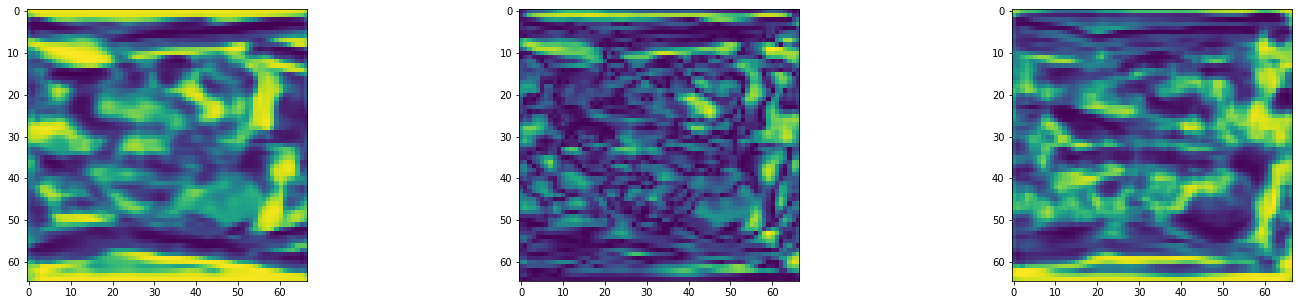

CT Pat:  11  :: MR Pat:  18
2 / 250
# reg iters before backprop: tensor([16])
Dice Start:  tensor([0.5796, 0.6062, 0.0274, 0.4499, 0.4389, 0.6241, 0.4901]) tensor(0.4595)
Dice Guided:  tensor([0.7993, 0.7701, 0.0648, 0.7117, 0.5858, 0.7268, 0.6998]) tensor(0.6226)
Dice 1 Step 0:  tensor([0.8121, 0.7839, 0.0829, 0.7248, 0.6050, 0.7507, 0.7296]) tensor(0.6413)
CT Pat:  7  :: MR Pat:  7
3 / 250
# reg iters before backprop: tensor([15])
Dice Start:  tensor([0.5633, 0.1539, 0.1880, 0.5145, 0.4057, 0.6416, 0.6678]) tensor(0.4478)
Dice Guided:  tensor([0.7493, 0.3133, 0.3901, 0.6860, 0.5567, 0.7290, 0.6987]) tensor(0.5890)
Dice 1 Step 0:  tensor([0.7661, 0.3042, 0.3889, 0.6996, 0.5796, 0.7271, 0.6885]) tensor(0.5934)
CT Pat:  9  :: MR Pat:  4
4 / 250
# reg iters before backprop: tensor([21])
Dice Start:  tensor([0.6352, 0.2895, 0.2075, 0.4549, 0.3248, 0.2698, 0.1773]) tensor(0.3370)
Dice Guided:  tensor([0.8082, 0.4316, 0.5443, 0.5706, 0.4984, 0.6049, 0.5825]) tensor(0.5772)
Dice 1 Step 0:  t

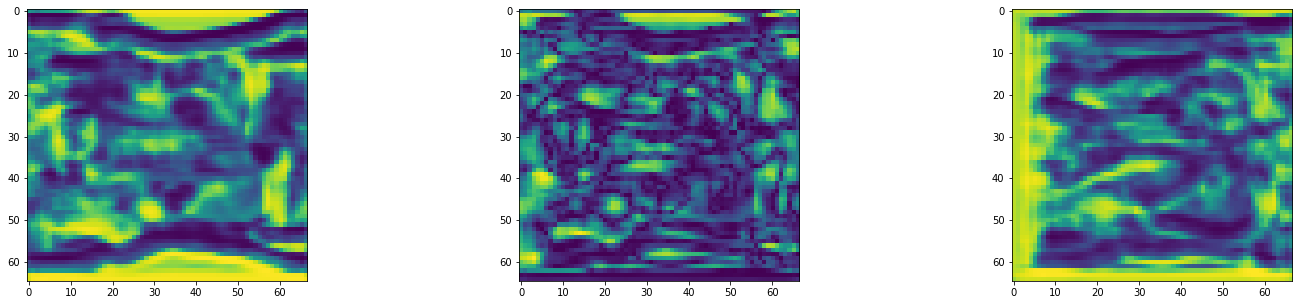

CT Pat:  10  :: MR Pat:  11
22 / 250
# reg iters before backprop: tensor([21])
Dice Start:  tensor([0.5481, 0.3503, 0.3508, 0.0764, 0.5342, 0.6155, 0.5278]) tensor(0.4290)
Dice Guided:  tensor([0.7417, 0.6086, 0.4816, 0.1667, 0.7695, 0.7324, 0.7424]) tensor(0.6061)
Dice 1 Step 0:  tensor([0.7457, 0.6086, 0.4872, 0.1687, 0.7960, 0.7308, 0.7391]) tensor(0.6109)
CT Pat:  18  :: MR Pat:  16
23 / 250
# reg iters before backprop: tensor([6])
Dice Start:  tensor([0.4421, 0.3868, 0.3929, 0.0000, 0.6189, 0.2870, 0.5556]) tensor(0.3833)
Dice Guided:  tensor([0.5187, 0.4504, 0.4338, 0.0000, 0.6940, 0.3403, 0.6628]) tensor(0.4429)
Dice 1 Step 0:  tensor([0.5142, 0.4724, 0.4261, 0.0000, 0.7146, 0.3484, 0.7019]) tensor(0.4539)
CT Pat:  14  :: MR Pat:  8
24 / 250
# reg iters before backprop: tensor([4])
Dice Start:  tensor([0.3187, 0.4268, 0.6222, 0.0641, 0.2911, 0.7294, 0.4731]) tensor(0.4179)
Dice Guided:  tensor([0.3541, 0.4816, 0.6684, 0.0708, 0.3461, 0.7337, 0.5161]) tensor(0.4530)
Dice 1 Step 0

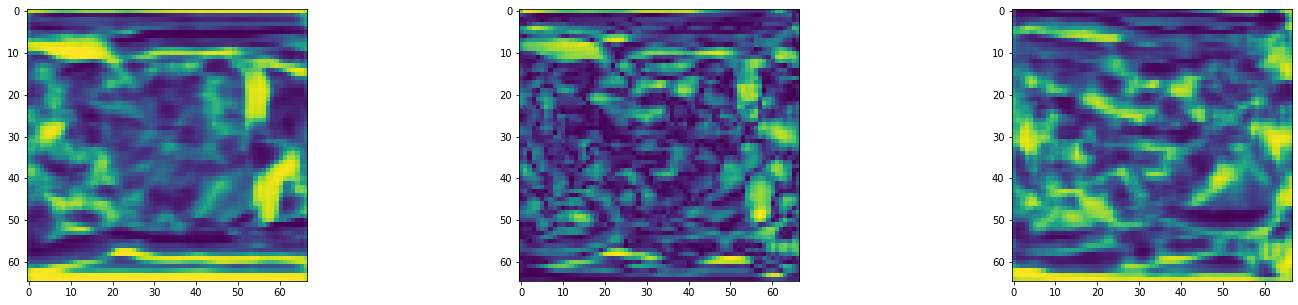

CT Pat:  15  :: MR Pat:  8
42 / 250
# reg iters before backprop: tensor([13])
Dice Start:  tensor([0.6779, 0.3819, 0.0000, 0.7542, 0.5495, 0.6805, 0.6628]) tensor(0.5296)
Dice Guided:  tensor([0.7894, 0.4989, 0.0000, 0.8422, 0.6924, 0.7493, 0.7222]) tensor(0.6135)
Dice 1 Step 0:  tensor([0.7975, 0.5144, 0.0000, 0.8388, 0.7055, 0.7376, 0.7327]) tensor(0.6181)
CT Pat:  14  :: MR Pat:  9
43 / 250
# reg iters before backprop: tensor([6])
Dice Start:  tensor([0.3187, 0.4268, 0.6222, 0.0641, 0.2911, 0.7294, 0.4731]) tensor(0.4179)
Dice Guided:  tensor([0.3699, 0.5054, 0.6943, 0.0729, 0.3794, 0.7342, 0.5710]) tensor(0.4753)
Dice 1 Step 0:  tensor([0.3729, 0.5276, 0.6897, 0.0721, 0.4177, 0.7410, 0.5468]) tensor(0.4811)
CT Pat:  20  :: MR Pat:  10
44 / 250
# reg iters before backprop: tensor([1])
Dice Start:  tensor([0.3906, 0.1319, 0.0000, 0.2282, 0.1537, 0.4020, 0.3995]) tensor(0.2437)
Dice Guided:  tensor([0.3906, 0.1319, 0.0000, 0.2282, 0.1537, 0.4020, 0.3995]) tensor(0.2437)
Dice 1 Step 0:

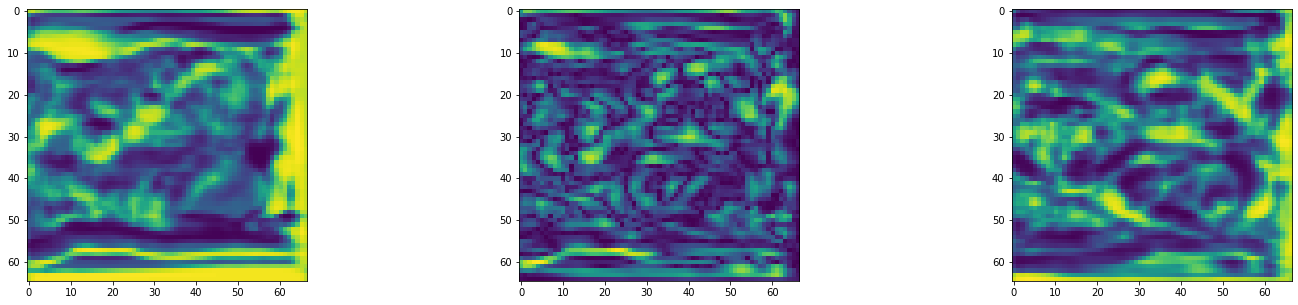

CT Pat:  10  :: MR Pat:  5
62 / 250
# reg iters before backprop: tensor([19])
Dice Start:  tensor([0.5481, 0.3503, 0.3508, 0.0764, 0.5342, 0.6155, 0.5278]) tensor(0.4290)
Dice Guided:  tensor([0.7276, 0.5854, 0.4734, 0.1491, 0.7600, 0.7240, 0.7377]) tensor(0.5939)
Dice 1 Step 0:  tensor([0.7328, 0.5889, 0.4827, 0.1581, 0.7850, 0.7245, 0.7334]) tensor(0.6008)
CT Pat:  14  :: MR Pat:  3
63 / 250
# reg iters before backprop: tensor([9])
Dice Start:  tensor([0.3187, 0.4268, 0.6222, 0.0641, 0.2911, 0.7294, 0.4731]) tensor(0.4179)
Dice Guided:  tensor([0.4010, 0.5444, 0.7020, 0.0921, 0.4242, 0.7442, 0.5866]) tensor(0.4992)
Dice 1 Step 0:  tensor([0.4077, 0.5720, 0.7044, 0.0901, 0.4674, 0.7499, 0.5842]) tensor(0.5108)
CT Pat:  9  :: MR Pat:  7
64 / 250
# reg iters before backprop: tensor([20])
Dice Start:  tensor([0.6352, 0.2895, 0.2075, 0.4549, 0.3248, 0.2698, 0.1773]) tensor(0.3370)
Dice Guided:  tensor([0.8045, 0.4248, 0.5277, 0.5667, 0.4908, 0.5928, 0.5586]) tensor(0.5666)
Dice 1 Step 0: 

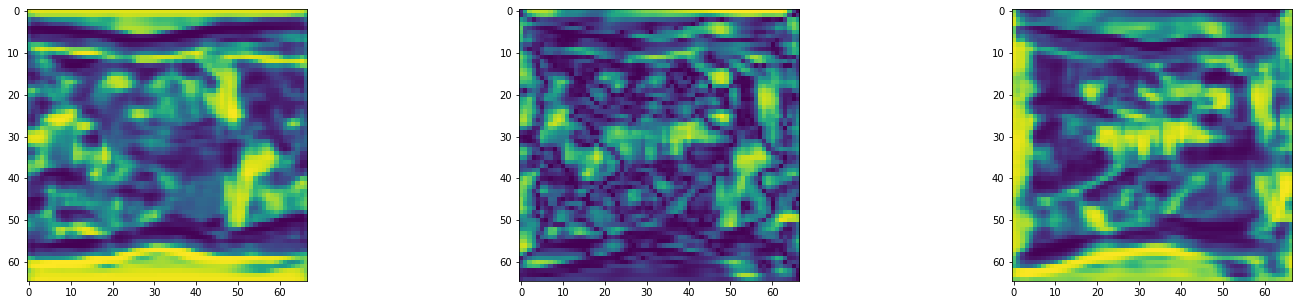

CT Pat:  4  :: MR Pat:  16
82 / 250
# reg iters before backprop: tensor([21])
Dice Start:  tensor([0.5625, 0.1399, 0.2257, 0.0990, 0.4619, 0.2268, 0.2907]) tensor(0.2866)
Dice Guided:  tensor([0.7731, 0.4859, 0.4863, 0.2363, 0.7190, 0.5616, 0.6751]) tensor(0.5625)
Dice 1 Step 0:  tensor([0.7798, 0.4992, 0.4775, 0.2482, 0.7266, 0.5635, 0.6822]) tensor(0.5681)
CT Pat:  11  :: MR Pat:  4
83 / 250
# reg iters before backprop: tensor([4])
Dice Start:  tensor([0.5796, 0.6062, 0.0274, 0.4499, 0.4389, 0.6241, 0.4901]) tensor(0.4595)
Dice Guided:  tensor([0.6410, 0.6394, 0.0258, 0.5366, 0.5063, 0.6905, 0.5941]) tensor(0.5191)
Dice 1 Step 0:  tensor([0.6701, 0.6727, 0.0815, 0.5750, 0.5075, 0.7082, 0.6011]) tensor(0.5452)
CT Pat:  14  :: MR Pat:  20
84 / 250
# reg iters before backprop: tensor([13])
Dice Start:  tensor([0.3187, 0.4268, 0.6222, 0.0641, 0.2911, 0.7294, 0.4731]) tensor(0.4179)
Dice Guided:  tensor([0.4357, 0.5943, 0.7309, 0.1043, 0.4778, 0.7575, 0.6124]) tensor(0.5304)
Dice 1 Step 0

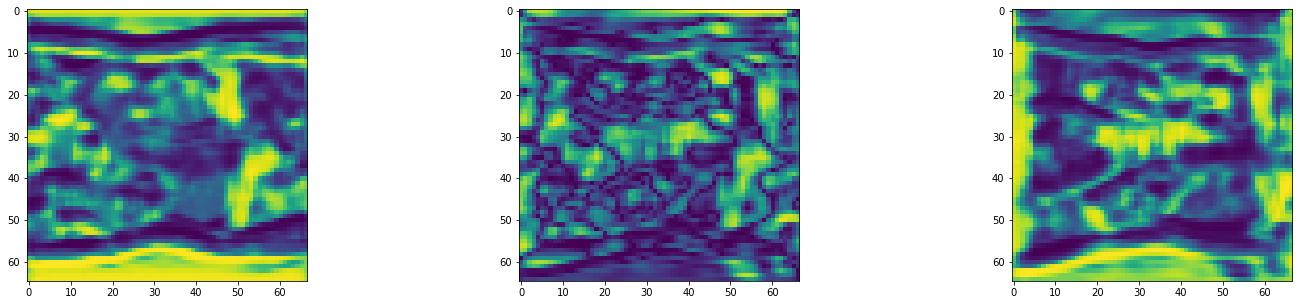

CT Pat:  20  :: MR Pat:  16
102 / 250
# reg iters before backprop: tensor([16])
Dice Start:  tensor([0.3906, 0.1319, 0.0000, 0.2282, 0.1537, 0.4020, 0.3995]) tensor(0.2437)
Dice Guided:  tensor([0.5610, 0.2425, 0.0000, 0.3428, 0.2487, 0.4623, 0.4985]) tensor(0.3365)
Dice 1 Step 0:  tensor([0.5499, 0.2247, 0.0000, 0.3591, 0.2536, 0.4878, 0.5056]) tensor(0.3401)
CT Pat:  4  :: MR Pat:  20
103 / 250
# reg iters before backprop: tensor([23])
Dice Start:  tensor([0.5625, 0.1399, 0.2257, 0.0990, 0.4619, 0.2268, 0.2907]) tensor(0.2866)
Dice Guided:  tensor([0.7863, 0.5190, 0.5080, 0.2492, 0.7320, 0.5862, 0.6832]) tensor(0.5806)
Dice 1 Step 0:  tensor([0.7911, 0.5344, 0.5032, 0.2709, 0.7378, 0.5922, 0.6858]) tensor(0.5879)
CT Pat:  4  :: MR Pat:  9
104 / 250
# reg iters before backprop: tensor([22])
Dice Start:  tensor([0.5625, 0.1399, 0.2257, 0.0990, 0.4619, 0.2268, 0.2907]) tensor(0.2866)
Dice Guided:  tensor([0.7807, 0.5038, 0.4993, 0.2411, 0.7255, 0.5830, 0.6834]) tensor(0.5738)
Dice 1 Ste

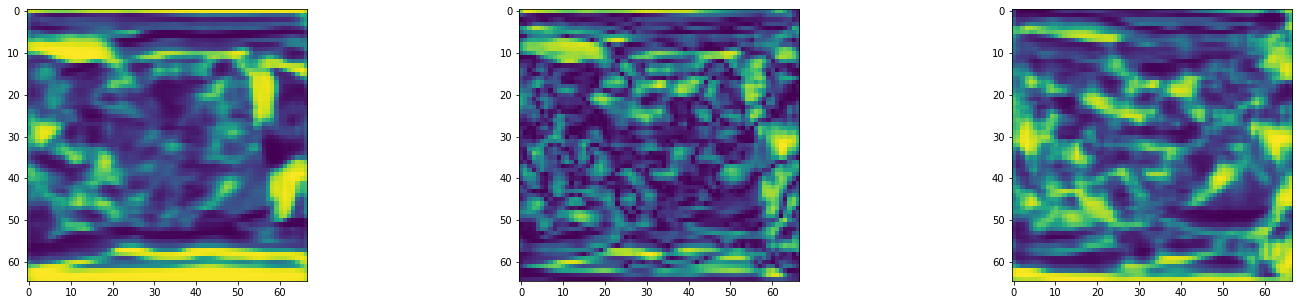

CT Pat:  7  :: MR Pat:  7
122 / 250
# reg iters before backprop: tensor([13])
Dice Start:  tensor([0.5633, 0.1539, 0.1880, 0.5145, 0.4057, 0.6416, 0.6678]) tensor(0.4478)
Dice Guided:  tensor([0.7252, 0.3003, 0.3532, 0.6730, 0.5361, 0.7240, 0.6929]) tensor(0.5721)
Dice 1 Step 0:  tensor([0.7402, 0.2909, 0.3554, 0.6787, 0.5677, 0.7154, 0.6832]) tensor(0.5759)
CT Pat:  7  :: MR Pat:  4
123 / 250
# reg iters before backprop: tensor([23])
Dice Start:  tensor([0.5633, 0.1539, 0.1880, 0.5145, 0.4057, 0.6416, 0.6678]) tensor(0.4478)
Dice Guided:  tensor([0.8237, 0.4087, 0.5179, 0.7563, 0.6236, 0.7401, 0.6994]) tensor(0.6528)
Dice 1 Step 0:  tensor([0.8324, 0.4072, 0.5244, 0.7638, 0.6530, 0.7493, 0.6904]) tensor(0.6601)
CT Pat:  8  :: MR Pat:  4
124 / 250
# reg iters before backprop: tensor([11])
Dice Start:  tensor([0.5573, 0.5133, 0.6145, 0.0000, 0.3910, 0.5691, 0.6101]) tensor(0.4650)
Dice Guided:  tensor([0.6491, 0.6285, 0.7089, 0.0000, 0.4653, 0.6750, 0.7066]) tensor(0.5476)
Dice 1 Step 0

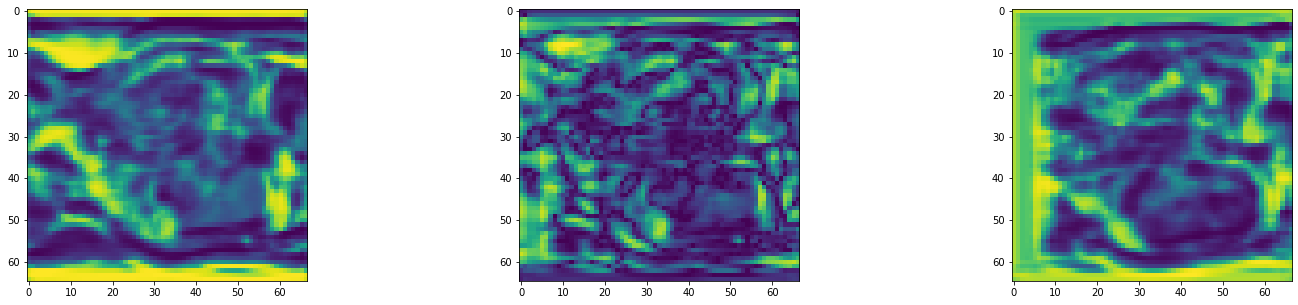

CT Pat:  8  :: MR Pat:  5
142 / 250
# reg iters before backprop: tensor([6])
Dice Start:  tensor([0.5573, 0.5133, 0.6145, 0.0000, 0.3910, 0.5691, 0.6101]) tensor(0.4650)
Dice Guided:  tensor([0.6073, 0.5833, 0.6808, 0.0000, 0.4456, 0.6437, 0.6722]) tensor(0.5190)
Dice 1 Step 0:  tensor([0.6122, 0.6143, 0.6832, 0.0000, 0.4411, 0.6485, 0.6627]) tensor(0.5231)
CT Pat:  18  :: MR Pat:  11
143 / 250
# reg iters before backprop: tensor([21])
Dice Start:  tensor([0.4421, 0.3868, 0.3929, 0.0000, 0.6189, 0.2870, 0.5556]) tensor(0.3833)
Dice Guided:  tensor([0.7061, 0.6263, 0.5154, 0.0000, 0.7994, 0.4380, 0.7878]) tensor(0.5533)
Dice 1 Step 0:  tensor([0.7371, 0.6664, 0.5270, 0.0000, 0.8190, 0.4359, 0.7976]) tensor(0.5690)
CT Pat:  1  :: MR Pat:  13
144 / 250
# reg iters before backprop: tensor([19])
Dice Start:  tensor([0.6773, 0.3542, 0.1163, 0.0000, 0.5702, 0.0103, 0.1273]) tensor(0.2651)
Dice Guided:  tensor([0.8180, 0.5680, 0.2144, 0.0000, 0.7697, 0.0502, 0.3331]) tensor(0.3933)
Dice 1 Step

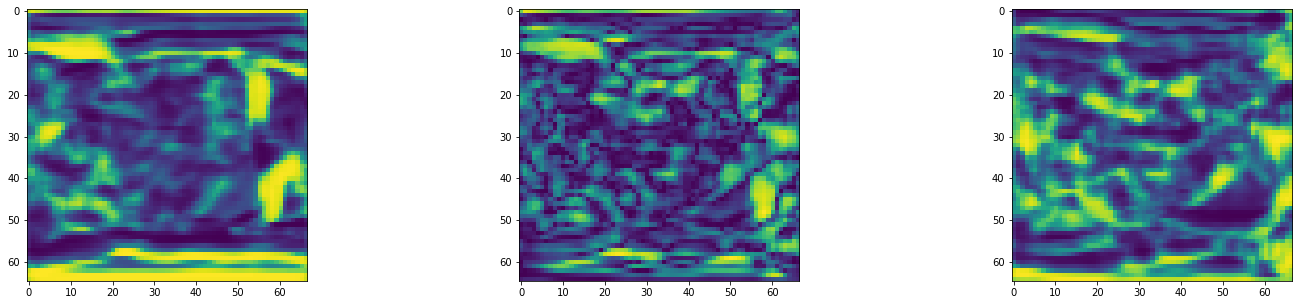

CT Pat:  5  :: MR Pat:  7
162 / 250
# reg iters before backprop: tensor([6])
Dice Start:  tensor([0.6432, 0.5674, 0.0027, 0.1552, 0.4418, 0.5746, 0.4866]) tensor(0.4102)
Dice Guided:  tensor([0.7165, 0.6568, 0.0031, 0.1694, 0.5265, 0.6311, 0.5801]) tensor(0.4691)
Dice 1 Step 0:  tensor([0.7268, 0.7031, 0.0029, 0.1857, 0.5845, 0.6392, 0.6015]) tensor(0.4920)
CT Pat:  14  :: MR Pat:  5
163 / 250
# reg iters before backprop: tensor([3])
Dice Start:  tensor([0.3187, 0.4268, 0.6222, 0.0641, 0.2911, 0.7294, 0.4731]) tensor(0.4179)
Dice Guided:  tensor([0.3494, 0.4722, 0.6378, 0.0655, 0.3374, 0.7294, 0.4946]) tensor(0.4409)
Dice 1 Step 0:  tensor([0.3461, 0.4922, 0.6525, 0.0705, 0.3542, 0.7331, 0.5126]) tensor(0.4516)
CT Pat:  18  :: MR Pat:  16
164 / 250
# reg iters before backprop: tensor([1])
Dice Start:  tensor([0.4421, 0.3868, 0.3929, 0.0000, 0.6189, 0.2870, 0.5556]) tensor(0.3833)
Dice Guided:  tensor([0.4421, 0.3868, 0.3929, 0.0000, 0.6189, 0.2870, 0.5556]) tensor(0.3833)
Dice 1 Step 0

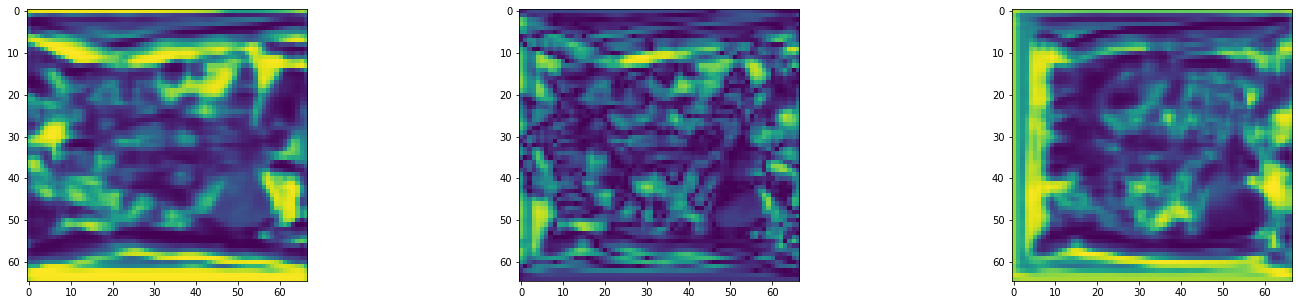

CT Pat:  11  :: MR Pat:  13
182 / 250
# reg iters before backprop: tensor([7])
Dice Start:  tensor([0.5796, 0.6062, 0.0274, 0.4499, 0.4389, 0.6241, 0.4901]) tensor(0.4595)
Dice Guided:  tensor([0.6887, 0.6938, 0.0279, 0.5903, 0.5131, 0.7207, 0.6072]) tensor(0.5488)
Dice 1 Step 0:  tensor([0.7230, 0.7185, 0.0847, 0.6175, 0.5350, 0.7182, 0.6773]) tensor(0.5820)
CT Pat:  18  :: MR Pat:  16
183 / 250
# reg iters before backprop: tensor([18])
Dice Start:  tensor([0.4421, 0.3868, 0.3929, 0.0000, 0.6189, 0.2870, 0.5556]) tensor(0.3833)
Dice Guided:  tensor([0.6685, 0.5929, 0.4977, 0.0000, 0.7766, 0.4216, 0.7721]) tensor(0.5328)
Dice 1 Step 0:  tensor([0.7016, 0.6324, 0.5089, 0.0000, 0.8081, 0.4223, 0.7907]) tensor(0.5520)
CT Pat:  10  :: MR Pat:  8
184 / 250
# reg iters before backprop: tensor([2])
Dice Start:  tensor([0.5481, 0.3503, 0.3508, 0.0764, 0.5342, 0.6155, 0.5278]) tensor(0.4290)
Dice Guided:  tensor([0.5532, 0.3503, 0.3508, 0.0764, 0.5342, 0.6155, 0.5278]) tensor(0.4298)
Dice 1 Ste

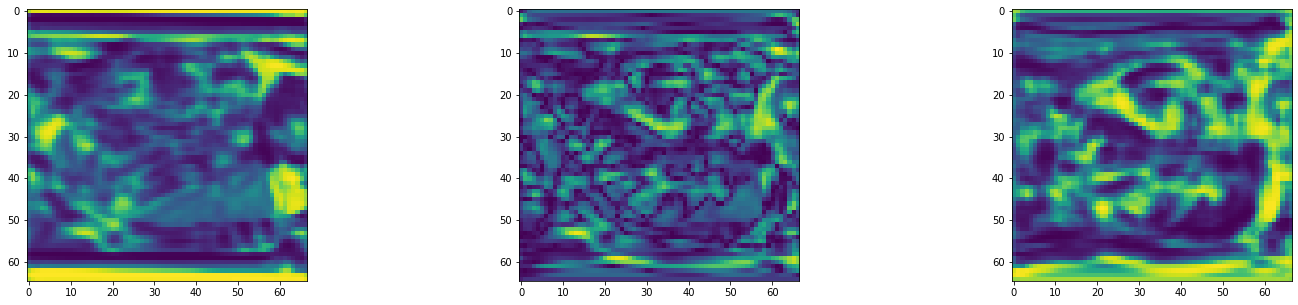

CT Pat:  4  :: MR Pat:  2
202 / 250
# reg iters before backprop: tensor([13])
Dice Start:  tensor([0.5625, 0.1399, 0.2257, 0.0990, 0.4619, 0.2268, 0.2907]) tensor(0.2866)
Dice Guided:  tensor([0.7091, 0.3362, 0.3961, 0.1860, 0.6322, 0.4497, 0.5805]) tensor(0.4700)
Dice 1 Step 0:  tensor([0.7148, 0.3339, 0.3907, 0.1971, 0.6460, 0.4585, 0.5954]) tensor(0.4766)
CT Pat:  9  :: MR Pat:  4
203 / 250
# reg iters before backprop: tensor([21])
Dice Start:  tensor([0.6352, 0.2895, 0.2075, 0.4549, 0.3248, 0.2698, 0.1773]) tensor(0.3370)
Dice Guided:  tensor([0.8082, 0.4316, 0.5443, 0.5706, 0.4984, 0.6049, 0.5825]) tensor(0.5772)
Dice 1 Step 0:  tensor([0.8144, 0.4366, 0.5843, 0.5841, 0.5014, 0.5957, 0.5952]) tensor(0.5874)
CT Pat:  8  :: MR Pat:  7
204 / 250
# reg iters before backprop: tensor([16])
Dice Start:  tensor([0.5573, 0.5133, 0.6145, 0.0000, 0.3910, 0.5691, 0.6101]) tensor(0.4650)
Dice Guided:  tensor([0.6824, 0.6692, 0.7345, 0.0000, 0.4941, 0.6878, 0.7227]) tensor(0.5701)
Dice 1 Step 0

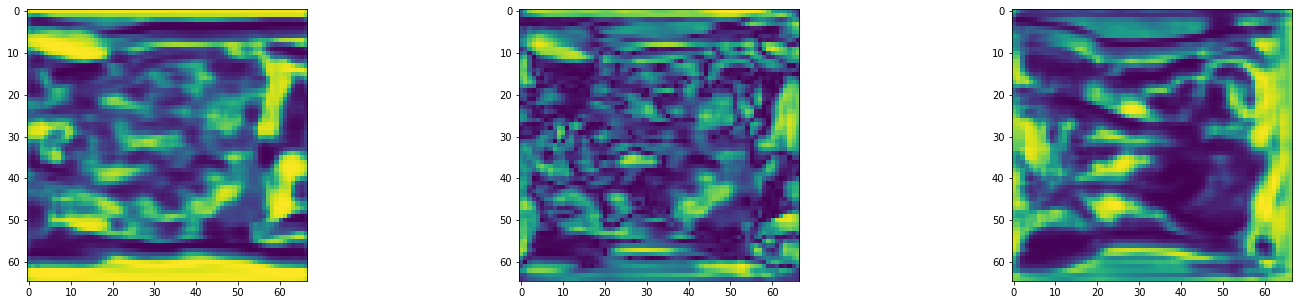

CT Pat:  10  :: MR Pat:  18
222 / 250
# reg iters before backprop: tensor([23])
Dice Start:  tensor([0.5481, 0.3503, 0.3508, 0.0764, 0.5342, 0.6155, 0.5278]) tensor(0.4290)
Dice Guided:  tensor([0.7546, 0.6235, 0.4903, 0.1807, 0.7818, 0.7388, 0.7454]) tensor(0.6164)
Dice 1 Step 0:  tensor([0.7630, 0.6410, 0.4990, 0.1884, 0.8026, 0.7460, 0.7546]) tensor(0.6278)
CT Pat:  18  :: MR Pat:  20
223 / 250
# reg iters before backprop: tensor([14])
Dice Start:  tensor([0.4421, 0.3868, 0.3929, 0.0000, 0.6189, 0.2870, 0.5556]) tensor(0.3833)
Dice Guided:  tensor([0.6187, 0.5398, 0.4717, 0.0000, 0.7622, 0.3917, 0.7615]) tensor(0.5065)
Dice 1 Step 0:  tensor([0.6509, 0.5850, 0.4847, 0.0000, 0.7872, 0.3979, 0.7742]) tensor(0.5257)
CT Pat:  8  :: MR Pat:  8
224 / 250
# reg iters before backprop: tensor([23])
Dice Start:  tensor([0.5573, 0.5133, 0.6145, 0.0000, 0.3910, 0.5691, 0.6101]) tensor(0.4650)
Dice Guided:  tensor([0.7222, 0.7101, 0.7804, 0.0000, 0.5259, 0.7079, 0.7437]) tensor(0.5986)
Dice 1 St

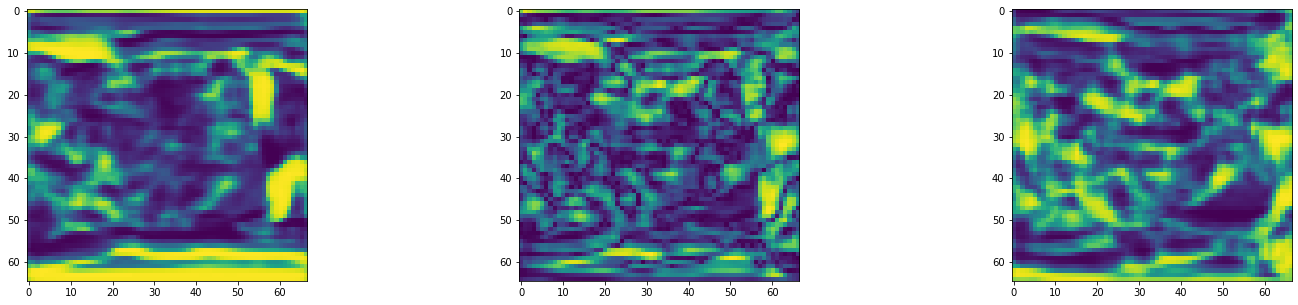

CT Pat:  1  :: MR Pat:  20
242 / 250
# reg iters before backprop: tensor([5])
Dice Start:  tensor([0.6773, 0.3542, 0.1163, 0.0000, 0.5702, 0.0103, 0.1273]) tensor(0.2651)
Dice Guided:  tensor([0.7325, 0.4220, 0.1424, 0.0000, 0.6267, 0.0076, 0.1749]) tensor(0.3009)
Dice 1 Step 0:  tensor([0.7452, 0.4309, 0.1439, 0.0000, 0.6696, 0.0203, 0.2036]) tensor(0.3162)
CT Pat:  7  :: MR Pat:  17
243 / 250
# reg iters before backprop: tensor([14])
Dice Start:  tensor([0.5633, 0.1539, 0.1880, 0.5145, 0.4057, 0.6416, 0.6678]) tensor(0.4478)
Dice Guided:  tensor([0.7383, 0.3094, 0.3705, 0.6774, 0.5446, 0.7268, 0.6938]) tensor(0.5801)
Dice 1 Step 0:  tensor([0.7563, 0.3018, 0.3684, 0.6923, 0.5804, 0.7189, 0.6843]) tensor(0.5861)
CT Pat:  5  :: MR Pat:  16
244 / 250
# reg iters before backprop: tensor([4])
Dice Start:  tensor([0.6432, 0.5674, 0.0027, 0.1552, 0.4418, 0.5746, 0.4866]) tensor(0.4102)
Dice Guided:  tensor([0.6854, 0.6329, 0.0027, 0.1602, 0.5055, 0.5861, 0.5592]) tensor(0.4474)
Dice 1 Step 

In [11]:
# TRAINING CELL:

dev_nr = 0
# decoupled dimensions
with torch.cuda.device(dev_nr):
    nr_pairs = 250 # nr of training image pairs 
    reg_iter = 15 # nr of maximum registration iterations per pair (random draw limit)
    feat_back_iter = 1 # nr of feature update computations per pair
    batch_back = 3
    lambda_reg = 5#0.5#25
    solver_iter = 3
    C_out = 12#2 # output-channel number
    sc_val = 0.70 # scaling value of network output (if <1.0: the last step in back_net sets this trilinear interp factor)
    loss_scale = 1*(10**0)#1*(10**0)
    
    loss_evo_sdm = torch.zeros(nr_pairs*feat_back_iter)
    loss_evo_hot = torch.zeros(nr_pairs*feat_back_iter)
    loss_evo = torch.zeros(nr_pairs*feat_back_iter)
    
    
    tune_MIND = torch.load('./mind_pretrained_net_70_2layer.pth').cuda().train()
    print('# Total Param: ', countParameters(tune_MIND))
    
    
    with torch.no_grad():
        # get output dimensions!
        test_in = torch.ones(1,1,D,H,W).cuda()
        test_out = tune_MIND(test_in,'ct')
        _,_,Ds,Hs,Ws = test_out.size()
    
    L = laplace(lambda_reg,Ds,Hs,Ws).cuda()
    L_u = laplace_block(lambda_reg,Ds,Hs,Ws,'u').cuda()
    L_m = laplace_block(lambda_reg,Ds,Hs,Ws,'m').cuda()
    L_l = laplace_block(lambda_reg,Ds,Hs,Ws,'l').cuda()
    
    u_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
    v_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
    w_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()

    id_grid = torch.nn.functional.affine_grid(torch.eye(3,4).view(1,3,4),(1,1,D,H,W)).cuda()

    avg3d = torch.nn.AvgPool3d(kernel_size=5,padding=2,stride=1)
    

    #optim = torch.optim.Adam(list(mov_net.parameters()) + 
    #                         list(fix_net.parameters()) +
    #                         list(back_net.parameters()), 
    #                         lr=0.00001)#,
    #                         #weight_decay=1e-2)
    optim = torch.optim.Adam(tune_MIND.parameters(), 
                             lr=0.00005)#,
                             #weight_decay=1e-2)
        
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim,0.985)
    metric = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0,25.0,35.0,5.0,35.0,35.0,35.0,35.0]).cuda())
    metric_SDM = torch.nn.MSELoss()#L1Loss()
    
    for pairdx in range(nr_pairs):
    # draw a new patient pair
        with torch.no_grad():
            rnd_ct = torch.randint(train_sz,(1,))
            rnd_mr = torch.randint(train_sz,(1,))
            img_fix, seg_fix, img_mov, seg_mov = get_ct_mr_pair(ct_train_pats[rnd_ct].item(), 
                                                                mr_train_pats[rnd_mr].item(),
                                                                sc_val)
            # perform random number of guided update steps
            rnd_iters = torch.randint(1,reg_iter+10,(1,))
            print((pairdx+1).__str__()+' / '+nr_pairs.__str__())
            print('# reg iters before backprop:', rnd_iters)
            guided_grid, sdm_fix, sdm_mov = perform_guided_updates(seg_mov, seg_fix, rnd_iters)
        
        # make a batch of 3...
        if pairdx % batch_back == 0:
            optim.zero_grad()
        
        for idx in range(feat_back_iter):

            # upscale displacement fields from last iteration
            with torch.no_grad():
                grid_up_km1 = torch.cat((w_km1.view(1,Ds,Hs,Ws,1),v_km1.view(1,Ds,Hs,Ws,1),u_km1.view(1,Ds,Hs,Ws,1)),4)
                grid_up_km1 = avg3d(grid_up_km1.permute(0,4,1,2,3))
                grid_up_km1 = torch.nn.functional.interpolate(grid_up_km1, size=(D,H,W)).permute(0,2,3,4,1)

                M_km1_full = torch.nn.functional.grid_sample(img_mov.view(1,1,D,H,W).cuda(), 
                                                             id_grid + guided_grid, # without last update... several
                                                             padding_mode='border') # times the same field to backprop!

                del grid_up_km1
                torch.cuda.empty_cache()


            # generate feature representation  ::: GRADIENT TRACKING FROM HERE ONWARDS
            M_km1 = tune_MIND(M_km1_full.detach(),'ct')
            fix = tune_MIND(img_fix.cuda().detach(),'mr')

            M_km1_dD = d_dD(M_km1)
            M_km1_dH = d_dH(M_km1)
            M_km1_dW = d_dW(M_km1)

            RHS_D = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dD.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,u_km1.view(Ds*Hs*Ws,1)).detach()
            RHS_H = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dH.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,v_km1.view(Ds*Hs*Ws,1)).detach()
            RHS_W = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dW.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,w_km1.view(Ds*Hs*Ws,1)).detach()

            MAT = torch.sparse.FloatTensor(3*Ds*Hs*Ws,3*Ds*Hs*Ws).cuda()
            
            M1_DD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dD**2).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            M1_DH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dD*M_km1_dH).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            M1_DW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dD*M_km1_dW).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            
            M1_HH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dH**2).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            M1_HW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dH*M_km1_dW).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            
            M1_WW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dW**2).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            
            
            MAT = MAT.add(M1_DD).add(L_u)
            MAT = MAT.add(M1_DH)
            MAT = MAT.add(M1_DW)
            
            MAT = MAT.add(M1_HH).add(L_m)
            MAT = MAT.add(M1_DH)
            MAT = MAT.add(M1_HW)
            
            MAT = MAT.add(M1_WW).add(L_l)
            MAT = MAT.add(M1_DW)
            MAT = MAT.add(M1_HW)

            RHS = torch.cat((RHS_D, RHS_H, RHS_W),0)
            
            wvu = mlg_solver(MAT,RHS,3)
        
            w_k = wvu[2*Ds*Hs*Ws:]*(2.0/(Ws-1.0)) 
            v_k = wvu[Ds*Hs*Ws:2*Ds*Hs*Ws]*(2.0/(Hs-1.0))
            u_k = wvu[:Ds*Hs*Ws]*(2.0/(Ds-1.0))

            u_km1_crnt = u_km1 + u_k#*0.25#25
            v_km1_crnt = v_km1 + v_k#*0.25#25
            w_km1_crnt = w_km1 + w_k#*0.25#25

            grid_km1_tmp = torch.cat((w_km1_crnt.view(1,1,Ds,Hs,Ws),
                                      v_km1_crnt.view(1,1,Ds,Hs,Ws),
                                      u_km1_crnt.view(1,1,Ds,Hs,Ws)),1)
            grid_km1_tmp = avg3d(grid_km1_tmp)
            grid_km1_tmp = torch.nn.functional.interpolate(grid_km1_tmp, size=(D,H,W),
                                                           mode='trilinear').permute(0,2,3,4,1)

            seg_mov_hot = torch.nn.functional.one_hot(seg_mov.long(),num_classes=8).squeeze().permute(3,0,1,2).unsqueeze(0).float()
            mov_seg_warp = torch.nn.functional.grid_sample(seg_mov_hot.view(1,8,D,H,W).cuda(), 
                                                           grid_km1_tmp + id_grid + guided_grid,
                                                           padding_mode='border')
            loss_hot = (loss_scale)*metric(mov_seg_warp.permute(0,2,3,4,1).view(-1,8),seg_fix.cuda().view(-1).long())
            #mov_seg_warp = torch.nn.functional.grid_sample(seg_mov.view(1,1,D,H,W).cuda(), 
            #                                               grid_km1_tmp + id_grid + guided_grid,
            #                                               padding_mode='border')
            #loss = (loss_scale*((mov_seg_warp-seg_fix.cuda())**2).sum())/img_mov.numel()
            # and backprop it 
            sdm_mov_warp = torch.nn.functional.grid_sample(sdm_mov.view(1,8,D,H,W).cuda(), 
                                                           grid_km1_tmp + id_grid,
                                                           padding_mode='border')
            loss_sdm = metric_SDM(sdm_mov_warp[:,1:,...], sdm_fix[:,1:,...])
            loss = loss_hot# + loss_sdm
            loss.backward()
            #optim.step()
            #optim.zero_grad()
            
            loss_evo_hot[pairdx*feat_back_iter+idx] = loss_hot.item()
            loss_evo_sdm[pairdx*feat_back_iter+idx] = loss_sdm.item()
            loss_evo[pairdx*feat_back_iter+idx] = loss.item()
            
            seg_mov_warp = torch.nn.functional.grid_sample(seg_mov.cuda(), 
                                                   grid_km1_tmp + id_grid + guided_grid,
                                                   mode='nearest',
                                                   padding_mode='border')
            print('Dice 1 Step '+idx.__str__()+': ',dice_coeff(seg_mov_warp.cpu(),seg_fix,max_label=8),dice_coeff(seg_mov_warp.cpu(),seg_fix,max_label=8).mean())
            
            del MAT, M1_DD, M1_DH, M1_DW, M1_HH, M1_HW, M1_WW, RHS_D, RHS_H, RHS_W, RHS
            del wvu, w_k, v_k, u_k
            del u_km1_crnt, v_km1_crnt, w_km1_crnt
            #del mov_seg_warp, loss, seg_mov_hot
            del sdm_mov_warp, seg_mov_warp, loss#, sdm_fix
            torch.cuda.empty_cache()

            if (feat_back_iter-1) == idx and 0 == pairdx % 20:
                plt_chan = 0
                plt_slice = 12*2
                plt.figure(figsize=(25,5))
                plt.subplot(133)
                plt.imshow(fix[0,plt_chan,:,plt_slice,:].detach().cpu().squeeze())
                plt.subplot(131)
                plt.imshow(M_km1[0,plt_chan,:,plt_slice,:].detach().cpu().squeeze())
                plt.subplot(132)
                plt.imshow(torch.abs(M_km1[0,plt_chan,:,plt_slice,:].detach().cpu().squeeze() - fix[0,plt_chan,:,plt_slice,:].detach().cpu().squeeze()))
                plt.show()
        
        if pairdx%batch_back == (batch_back-1):
            optim.step()
            #scheduler.step()
        

    #plt.figure(figsize=(12,4))
    #plt.subplot(131)
    #plt.plot(loss_evo.numpy())
    #plt.subplot(132)
    #plt.plot(loss_evo_hot.numpy())
    #plt.subplot(133)
    #plt.plot(loss_evo_sdm.numpy())
    
    #mov_net = mov_net.eval()
    #fix_net = fix_net.eval()
    #back_net = back_net.eval()
    tune_MIND = tune_MIND.eval()
    
    torch.save(tune_MIND.cpu().eval(),'./mind_tuned_net_70_2layer.pth')

before:  tensor([0.5796, 0.6062, 0.0274, 0.4499, 0.4389, 0.6241, 0.4901]) tensor(0.4595)
after:  tensor([0.7654, 0.7497, 0.0886, 0.6748, 0.5538, 0.7311, 0.6932]) tensor(0.6081)


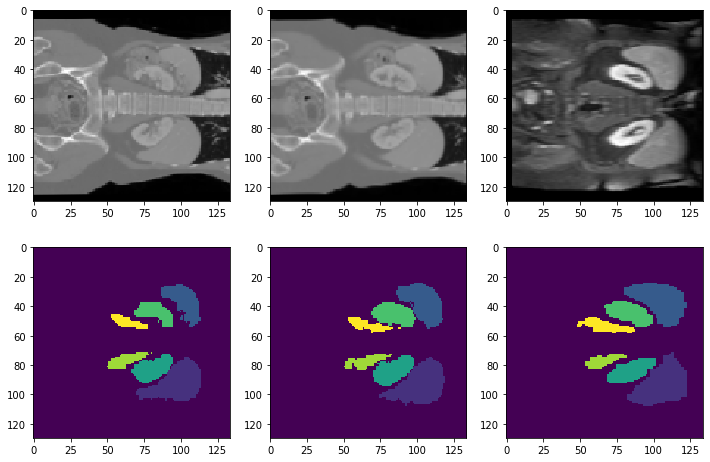

In [12]:
with torch.no_grad():
    
    seg_mov_warp = torch.nn.functional.grid_sample(seg_mov.cuda(), 
                                                   grid_km1_tmp + id_grid + guided_grid,
                                                   mode='nearest',
                                                   padding_mode='border')
    
    print('before: ',dice_coeff(seg_mov.cpu(),seg_fix,max_label=8),dice_coeff(seg_mov.cpu(),seg_fix,max_label=8).mean())
    print('after: ',dice_coeff(seg_mov_warp.cpu(),seg_fix,max_label=8),dice_coeff(seg_mov_warp.cpu(),seg_fix,max_label=8).mean())
    
    
    img_mov_warp = torch.nn.functional.grid_sample(img_mov.cuda(), 
                                                   grid_km1_tmp + id_grid + guided_grid,
                                                   mode='bilinear',
                                                   padding_mode='border')
    
    plt.figure(figsize=(12,8))
    plt_sl = 35
    plt.subplot(231)
    plt.imshow(img_mov.cpu()[0,0,:,plt_sl,:],'gray')
    plt.subplot(232)
    plt.imshow(img_mov_warp.cpu()[0,0,:,plt_sl,:],'gray')
    plt.subplot(233)
    plt.imshow(img_fix.cpu()[0,0,:,plt_sl,:],'gray')
    plt.subplot(234)
    plt.imshow(seg_mov.cpu()[0,0,:,plt_sl,:])
    plt.subplot(235)
    plt.imshow(seg_mov_warp.cpu()[0,0,:,plt_sl,:])
    plt.subplot(236)
    plt.imshow(seg_fix.cpu()[0,0,:,plt_sl,:])

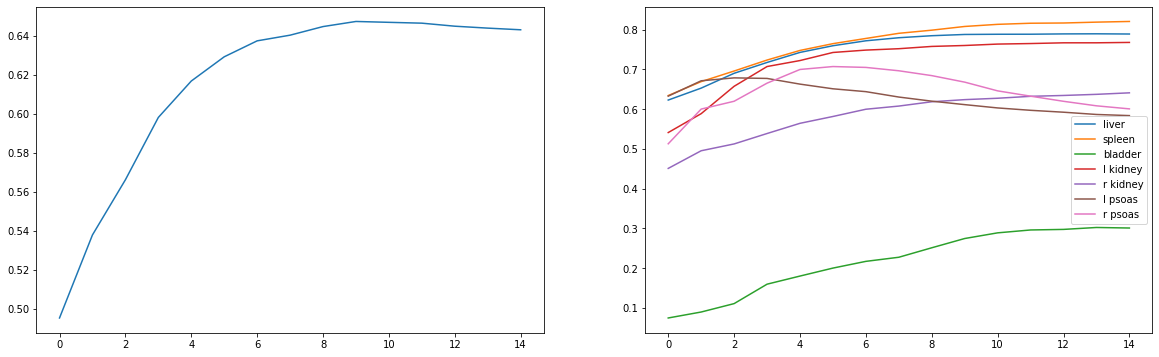

In [13]:
# try to use the same networks on the last training pair (check if at least overfitting works...)
with torch.no_grad():
    dev_nr = 0
    # decoupled dimensions
    with torch.cuda.device(dev_nr):
        reg_iter = 15#5
        lambda_reg = 5#1.5#25
        solver_iter = 3
        #C_out = 4#2#8

        dice_evo = torch.zeros(reg_iter,7)
        
        tune_MIND = tune_MIND.cuda().eval()
        
        # get output dimensions!
        test_in = torch.ones(1,1,D,H,W).cuda()
        test_out = tune_MIND(test_in,'ct')
        #test_out = back_net(test_in,0.25)
        _,_,Ds,Hs,Ws = test_out.size()

        L = laplace(lambda_reg,Ds,Hs,Ws).cuda()
        L_u = laplace_block(lambda_reg,Ds,Hs,Ws,'u').cuda()
        L_m = laplace_block(lambda_reg,Ds,Hs,Ws,'m').cuda()
        L_l = laplace_block(lambda_reg,Ds,Hs,Ws,'l').cuda()
        
        u_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
        v_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
        w_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()

        id_grid = torch.nn.functional.affine_grid(torch.eye(3,4).view(1,3,4),(1,1,D,H,W)).cuda()

        avg3d = torch.nn.AvgPool3d(kernel_size=5,padding=2,stride=1)

        #mov_net = mov_net.eval()
        #fix_net = fix_net.eval()
        #back_net = back_net.eval()
        tune_MIND = tune_MIND.eval()
        
        for idx in range(reg_iter):
            
            # upscale displacement fields
            with torch.no_grad():
                grid_up_km1 = torch.cat((w_km1.view(1,Ds,Hs,Ws,1),v_km1.view(1,Ds,Hs,Ws,1),u_km1.view(1,Ds,Hs,Ws,1)),4)
                grid_up_km1 = avg3d(grid_up_km1.permute(0,4,1,2,3))
                #grid_up_km1 = grid_up_km1.permute(0,4,1,2,3)
                grid_up_km1 = torch.nn.functional.interpolate(grid_up_km1, size=(D,H,W)).permute(0,2,3,4,1)

                M_km1_full = torch.nn.functional.grid_sample(img_mov.view(1,1,D,H,W).cuda(), 
                                                             grid_up_km1 + id_grid,
                                                             padding_mode='border')


            # generate feature representation
            M_km1 = tune_MIND(M_km1_full.detach(),'ct')
            fix = tune_MIND(img_fix.cuda().detach(),'mr')

            M_km1_dD = d_dD(M_km1)
            M_km1_dH = d_dH(M_km1)
            M_km1_dW = d_dW(M_km1)

            RHS_D = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dD.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,u_km1.view(Ds*Hs*Ws,1))
            RHS_H = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dH.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,v_km1.view(Ds*Hs*Ws,1))
            RHS_W = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dW.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,w_km1.view(Ds*Hs*Ws,1))

            MAT = torch.sparse.FloatTensor(3*Ds*Hs*Ws,3*Ds*Hs*Ws).cuda()
            
            M1_DD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dD**2).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            M1_DH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dD*M_km1_dH).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            M1_DW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dD*M_km1_dW).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            
            M1_HH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dH**2).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            M1_HD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dH*M_km1_dD).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            M1_HW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dH*M_km1_dW).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            
            M1_WW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dW**2).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            M1_WD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dW*M_km1_dD).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            M1_WH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                             (M_km1_dW*M_km1_dH).sum(1).view(-1),
                                             torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
            
            
            MAT = MAT.add(M1_DD).add(L_u)
            MAT = MAT.add(M1_DH)
            MAT = MAT.add(M1_DW)
            
            MAT = MAT.add(M1_HH).add(L_m)
            MAT = MAT.add(M1_HD)
            MAT = MAT.add(M1_HW)
            
            MAT = MAT.add(M1_WW).add(L_l)
            MAT = MAT.add(M1_WD)
            MAT = MAT.add(M1_WH)

            RHS = torch.cat((RHS_D, RHS_H, RHS_W),0)
            
            wvu = mlg_solver(MAT,RHS,3)
        
            w_k = wvu[2*Ds*Hs*Ws:]*(2.0/(Ws-1.0)) 
            v_k = wvu[Ds*Hs*Ws:2*Ds*Hs*Ws]*(2.0/(Hs-1.0))
            u_k = wvu[:Ds*Hs*Ws]*(2.0/(Ds-1.0))

            u_km1_crnt = u_km1 + u_k#*0.05#25
            v_km1_crnt = v_km1 + v_k#*0.05#25
            w_km1_crnt = w_km1 + w_k#*0.05#25
            
            grid_km1_tmp = torch.cat((w_km1_crnt.view(1,1,Ds,Hs,Ws),
                                      v_km1_crnt.view(1,1,Ds,Hs,Ws),
                                      u_km1_crnt.view(1,1,Ds,Hs,Ws)),1)
            grid_km1_tmp = avg3d(grid_km1_tmp)
            grid_km1_tmp = torch.nn.functional.interpolate(grid_km1_tmp, size=(D,H,W),
                                                           mode='trilinear').permute(0,2,3,4,1)
            
            u_km1 = u_km1_crnt.clone().detach()
            v_km1 = v_km1_crnt.clone().detach()
            w_km1 = w_km1_crnt.clone().detach()

            seg_mov_warp = torch.nn.functional.grid_sample(seg_mov.cuda(), 
                                                   grid_km1_tmp + id_grid,
                                                   mode='nearest',
                                                   padding_mode='border')
            dice_evo[idx,:] = dice_coeff(seg_mov_warp.cpu(),seg_fix,max_label=8)
        
        plt.figure(figsize=(20,6))
        plt.subplot(121)
        plt.plot(dice_evo.mean(1).cpu().numpy())
        plt.subplot(122)
        plt.plot(dice_evo.cpu().numpy())
        plt.legend(labels=["liver","spleen","bladder","l kidney","r kidney", "l psoas", "r psoas"])

before:  tensor([0.5796, 0.6062, 0.0274, 0.4499, 0.4389, 0.6241, 0.4901]) tensor(0.4595)
after:  tensor([0.7888, 0.8203, 0.3007, 0.7676, 0.6408, 0.5835, 0.6004]) tensor(0.6432)


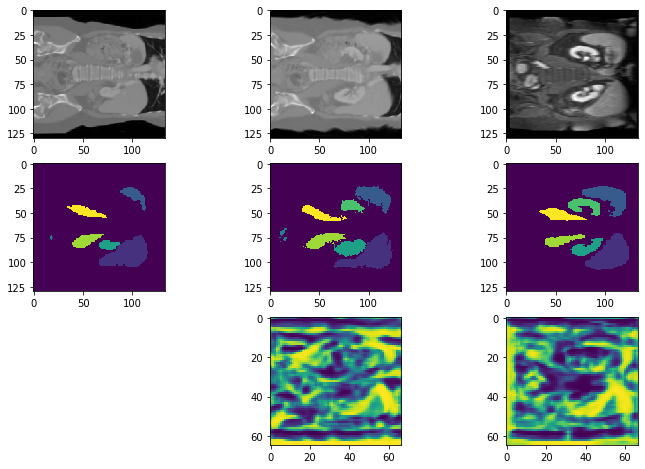

In [14]:
with torch.no_grad():
    seg_mov_warp = torch.nn.functional.grid_sample(seg_mov.cuda(), 
                                                   grid_km1_tmp + id_grid,
                                                   mode='nearest',
                                                   padding_mode='border')
    
    print('before: ',dice_coeff(seg_mov.cpu(),seg_fix,max_label=8),dice_coeff(seg_mov.cpu(),seg_fix,max_label=8).mean())
    print('after: ',dice_coeff(seg_mov_warp.cpu(),seg_fix,max_label=8),dice_coeff(seg_mov_warp.cpu(),seg_fix,max_label=8).mean())
    
    
    img_mov_warp = torch.nn.functional.grid_sample(img_mov.cuda(), 
                                                   grid_km1_tmp + id_grid,
                                                   #mode='bilinear',
                                                   padding_mode='border')
    
    plt.figure(figsize=(12,8))
    plt_sl = 40
    plt_slice = 10*2
    plt_chan = 3
    plt.subplot(3,3,1)
    plt.imshow(img_mov.cpu()[0,0,:,plt_sl,:],'gray')
    plt.subplot(3,3,2)
    plt.imshow(img_mov_warp.cpu()[0,0,:,plt_sl,:],'gray')
    plt.subplot(3,3,3)
    plt.imshow(img_fix.cpu()[0,0,:,plt_sl,:],'gray')
    plt.subplot(3,3,4)
    plt.imshow(seg_mov.cpu()[0,0,:,plt_sl,:])
    plt.subplot(3,3,5)
    plt.imshow(seg_mov_warp.cpu()[0,0,:,plt_sl,:])
    plt.subplot(3,3,6)
    plt.imshow(seg_fix.cpu()[0,0,:,plt_sl,:])
    plt.subplot(3,3,8)
    plt.imshow(M_km1.cpu()[0,plt_chan,:,plt_slice,:])
    plt.subplot(3,3,9)
    plt.imshow(fix.cpu()[0,plt_chan,:,plt_slice,:])

In [15]:
# save the networks!
#torch.save(fix_net,'./fix_net.pth')
#torch.save(mov_net,'./mov_net.pth')
#torch.save(back_net,'./back_net.pth')



In [92]:
# generate test pairs that will be used for all three compared methods (SUITS,MIND,SimpleElastix)
with torch.no_grad():
    torch.manual_seed(1909) # BVB!
    # fix MR, mov CT
    
    nr_test_pairs = 25
    
    #build all possible test_combinations
    tpat1_vec = (torch.arange(test_sz)).view(1,-1).repeat(1,test_sz).view(1,-1)
    tpat2_vec = (torch.arange(test_sz)).view(-1,1).repeat(1,test_sz).view(1,-1)
    tpat_pairs = torch.cat((tpat1_vec,tpat2_vec),0)
    tpat_rnd_idx = torch.randperm(tpat_pairs.size(1))[:nr_test_pairs]
    rnd_ct_test = tpat_pairs[0,tpat_rnd_idx]
    rnd_mr_test = tpat_pairs[1,tpat_rnd_idx]   
    
    
    #img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[0].item(), mr_test_pats[0].item(), 0.55)#0.65
    img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[rnd_ct_test[0]].item(), mr_test_pats[rnd_mr_test[0]].item(), 0.70)
    B,C,D,H,W = img_fix_t.size()

CT Pat:  2  :: MR Pat:  1


In [93]:
print(rnd_ct_test)
print(rnd_mr_test)
print(ct_test_pats[rnd_ct_test])
print(mr_test_pats[rnd_mr_test])

tensor([0, 4, 2, 4, 1, 5, 5, 2, 5, 1, 5, 5, 3, 0, 3, 2, 2, 2, 1, 3, 0, 2, 0, 4,
        3])
tensor([2, 5, 2, 2, 2, 1, 3, 1, 0, 4, 4, 2, 1, 4, 3, 4, 0, 3, 1, 0, 1, 5, 5, 3,
        4])
tensor([ 2, 17, 13, 17, 19, 12, 12, 13, 12, 19, 12, 12,  3,  2,  3, 13, 13, 13,
        19,  3,  2, 13,  2, 17,  3])
tensor([ 1, 19,  1,  1,  1, 14,  6, 14, 15, 12, 12,  1, 14, 12,  6, 12, 15,  6,
        14, 15, 14, 19, 19,  6, 12])


1 / 25
CT Pat:  2  :: MR Pat:  1
2 / 25
CT Pat:  17  :: MR Pat:  19
3 / 25
CT Pat:  13  :: MR Pat:  1
4 / 25
CT Pat:  17  :: MR Pat:  1
5 / 25
CT Pat:  19  :: MR Pat:  1
6 / 25
CT Pat:  12  :: MR Pat:  14
7 / 25
CT Pat:  12  :: MR Pat:  6
8 / 25
CT Pat:  13  :: MR Pat:  14
9 / 25
CT Pat:  12  :: MR Pat:  15
10 / 25
CT Pat:  19  :: MR Pat:  12
11 / 25
CT Pat:  12  :: MR Pat:  12
12 / 25
CT Pat:  12  :: MR Pat:  1
13 / 25
CT Pat:  3  :: MR Pat:  14
14 / 25
CT Pat:  2  :: MR Pat:  12
15 / 25
CT Pat:  3  :: MR Pat:  6
16 / 25
CT Pat:  13  :: MR Pat:  12
17 / 25
CT Pat:  13  :: MR Pat:  15
18 / 25
CT Pat:  13  :: MR Pat:  6
19 / 25
CT Pat:  19  :: MR Pat:  14
20 / 25
CT Pat:  3  :: MR Pat:  15
21 / 25
CT Pat:  2  :: MR Pat:  14
22 / 25
CT Pat:  13  :: MR Pat:  19
23 / 25
CT Pat:  2  :: MR Pat:  19
24 / 25
CT Pat:  17  :: MR Pat:  6
25 / 25
CT Pat:  3  :: MR Pat:  12


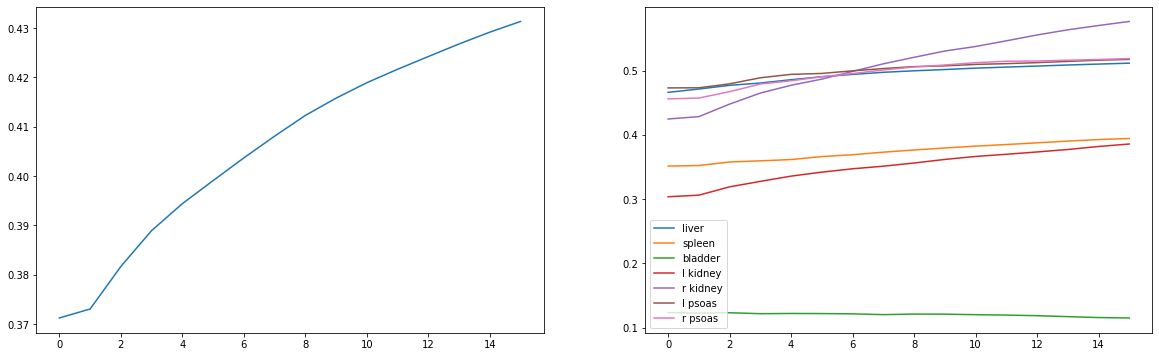

In [94]:
# try to use a MIND_pretrained network...
with torch.no_grad():
    dev_nr = 0
    reg_iter = 15#5
    lambda_reg = 10#50#25
    sc_val = 1.0
    solver_iter = 3
    C_out = 12#8
    
    dice_evo_net_pre = torch.zeros(nr_test_pairs,reg_iter+1,7)
    
    if flag_all:
    
        for tpdx in range(nr_test_pairs):
            print((tpdx+1).__str__()+' / '+nr_test_pairs.__str__())
            # decoupled dimensions
            with torch.cuda.device(dev_nr):
                pre_MINDNet = torch.load('./mind_pretrained_net_70_2layer.pth')
                pre_MINDNet = pre_MINDNet.cuda().eval()

                #img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[tpdx].item(), mr_test_pats[tpdx].item(), 0.55)#0.65
                img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[rnd_ct_test[tpdx]].item(), mr_test_pats[rnd_mr_test[tpdx]].item(), 0.70)
                dice_evo_net_pre[tpdx,0,:] = dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8)

                # get output dimensions!
                test_in = torch.ones(1,1,D,H,W).cuda()
                test_out = pre_MINDNet(test_in,'ct')
                #test_out = back_net(test_in,0.25)
                _,_,Ds,Hs,Ws = test_out.size()

                L = laplace(lambda_reg,Ds,Hs,Ws).cuda()
                L_u = laplace_block(lambda_reg,Ds,Hs,Ws,'u').cuda()
                L_m = laplace_block(lambda_reg,Ds,Hs,Ws,'m').cuda()
                L_l = laplace_block(lambda_reg,Ds,Hs,Ws,'l').cuda()

                u_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
                v_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
                w_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()

                id_grid = torch.nn.functional.affine_grid(torch.eye(3,4).view(1,3,4),(1,1,D,H,W)).cuda()

                avg3d = torch.nn.AvgPool3d(kernel_size=5,padding=2,stride=1)


                for idx in range(reg_iter):

                    # upscale displacement fields
                    with torch.no_grad():
                        grid_up_km1 = torch.cat((w_km1.view(1,Ds,Hs,Ws,1),v_km1.view(1,Ds,Hs,Ws,1),u_km1.view(1,Ds,Hs,Ws,1)),4)
                        grid_up_km1 = avg3d(grid_up_km1.permute(0,4,1,2,3))
                        grid_up_km1 = torch.nn.functional.interpolate(grid_up_km1, size=(D,H,W)).permute(0,2,3,4,1)

                        M_km1_full = torch.nn.functional.grid_sample(img_mov_t.view(1,1,D,H,W).cuda(), 
                                                                     grid_up_km1 + id_grid,
                                                                     padding_mode='border')


                    # generate feature representation
                    M_km1 = pre_MINDNet(M_km1_full.detach(),'ct')
                    fix = pre_MINDNet(img_fix_t.cuda().detach(),'mr')

                    #M_km1 = back_net(M_km1_full.detach(),0.25)
                    #fix = back_net(img_fix.cuda().detach(),0.25)

                    M_km1_dD = d_dD(M_km1)
                    M_km1_dH = d_dH(M_km1)
                    M_km1_dW = d_dW(M_km1)

                    RHS_D = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dD.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,u_km1.view(Ds*Hs*Ws,1))
                    RHS_H = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dH.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,v_km1.view(Ds*Hs*Ws,1))
                    RHS_W = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dW.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,w_km1.view(Ds*Hs*Ws,1))

                    MAT = torch.sparse.FloatTensor(3*Ds*Hs*Ws,3*Ds*Hs*Ws).cuda()

                    M1_DD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dD**2).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_DH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dD*M_km1_dH).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_DW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dD*M_km1_dW).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()

                    M1_HH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dH**2).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_HD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dH*M_km1_dD).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_HW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dH*M_km1_dW).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()

                    M1_WW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dW**2).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_WD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dW*M_km1_dD).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_WH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dW*M_km1_dH).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()


                    MAT = MAT.add(M1_DD).add(L_u)
                    MAT = MAT.add(M1_DH)
                    MAT = MAT.add(M1_DW)

                    MAT = MAT.add(M1_HD)
                    MAT = MAT.add(M1_HH).add(L_m)
                    MAT = MAT.add(M1_HW)

                    MAT = MAT.add(M1_WD)
                    MAT = MAT.add(M1_WH)
                    MAT = MAT.add(M1_WW).add(L_l)

                    RHS = torch.cat((RHS_D, RHS_H, RHS_W),0)

                    wvu = mlg_solver(MAT,RHS,3)

                    w_k = wvu[2*Ds*Hs*Ws:]*(2.0/(Ws-1.0)) 
                    v_k = wvu[Ds*Hs*Ws:2*Ds*Hs*Ws]*(2.0/(Hs-1.0))
                    u_k = wvu[:Ds*Hs*Ws]*(2.0/(Ds-1.0))

                    u_km1_crnt = u_km1 + u_k#*0.05#25
                    v_km1_crnt = v_km1 + v_k#*0.05#25
                    w_km1_crnt = w_km1 + w_k#*0.05#25

                    grid_km1_tmp = torch.cat((w_km1_crnt.view(1,1,Ds,Hs,Ws),
                                              v_km1_crnt.view(1,1,Ds,Hs,Ws),
                                              u_km1_crnt.view(1,1,Ds,Hs,Ws)),1)
                    grid_km1_tmp = avg3d(grid_km1_tmp)
                    grid_km1_tmp = torch.nn.functional.interpolate(grid_km1_tmp, size=(D,H,W),
                                                                   mode='trilinear').permute(0,2,3,4,1)

                    u_km1 = u_km1_crnt.clone().detach()
                    v_km1 = v_km1_crnt.clone().detach()
                    w_km1 = w_km1_crnt.clone().detach()

                    seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                                   grid_km1_tmp + id_grid,
                                                                   mode='nearest',
                                                                   padding_mode='border')
                    dice_evo_net_pre[tpdx,idx+1,:] = dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8)

    plt.figure(figsize=(20,6))
    plt.subplot(121)
    plt.plot(dice_evo_net_pre.mean(0).mean(1).cpu().numpy())
    plt.subplot(122)
    plt.plot(dice_evo_net_pre.mean(0).cpu().numpy())
    plt.legend(labels=["liver","spleen","bladder","l kidney","r kidney", "l psoas", "r psoas"])

before:  tensor([0.6758, 0.6241, 0.0000, 0.6948, 0.7423, 0.5189, 0.5185]) tensor(0.5392)
after:  tensor([0.6913, 0.5767, 0.0000, 0.8304, 0.8384, 0.5017, 0.4796]) tensor(0.5597)
torch.Size([1, 12, 65, 48, 67])


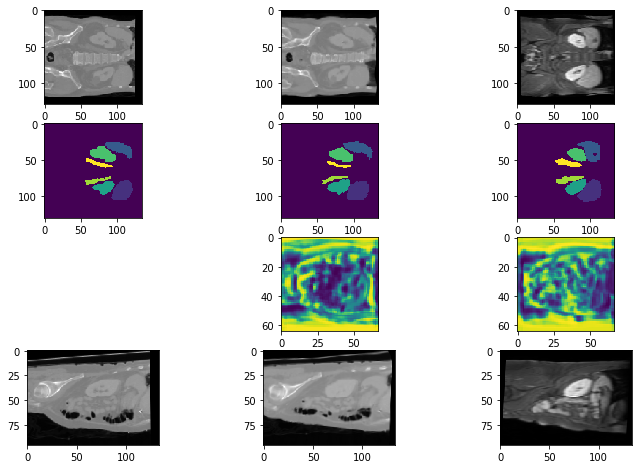

In [95]:
with torch.no_grad():
    if flag_all:
        seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                       grid_km1_tmp + id_grid,
                                                       mode='nearest',
                                                       padding_mode='border')

        print('before: ',dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8),dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8).mean())
        print('after: ',dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8),dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8).mean())


        img_mov_warp = torch.nn.functional.grid_sample(img_mov_t.cuda(), 
                                                       grid_km1_tmp + id_grid,
                                                       #mode='bilinear',
                                                       padding_mode='border')

        print(fix.size())

        plt.figure(figsize=(12,8))
        plt_sl = 35
        plt_slice = 30
        plt_chan = 8
        plt.subplot(4,3,1)
        plt.imshow(img_mov_t.cpu()[0,0,:,plt_sl,:],'gray')
        plt.subplot(4,3,2)
        plt.imshow(img_mov_warp.cpu()[0,0,:,plt_sl,:],'gray')
        plt.subplot(4,3,3)
        plt.imshow(img_fix_t.cpu()[0,0,:,plt_sl,:],'gray')
        plt.subplot(4,3,4)
        plt.imshow(seg_mov_t.cpu()[0,0,:,plt_sl,:])
        plt.subplot(4,3,5)
        plt.imshow(seg_mov_warp.cpu()[0,0,:,plt_sl,:])
        plt.subplot(4,3,6)
        plt.imshow(seg_fix_t.cpu()[0,0,:,plt_sl,:])
        plt.subplot(4,3,8)
        plt.imshow(M_km1.cpu()[0,plt_chan,:,plt_slice,:])
        plt.subplot(4,3,9)
        plt.imshow(fix.cpu()[0,plt_chan,:,plt_slice,:])
        plt.subplot(4,3,10)
        plt.imshow(img_mov_t.cpu()[0,0,40,:,:],'gray')
        plt.subplot(4,3,11)
        plt.imshow(img_mov_warp.cpu()[0,0,40,:,:],'gray')
        plt.subplot(4,3,12)
        plt.imshow(img_fix_t.cpu()[0,0,40,:,:],'gray')

1 / 25
CT Pat:  2  :: MR Pat:  1
2 / 25
CT Pat:  17  :: MR Pat:  19
3 / 25
CT Pat:  13  :: MR Pat:  1
4 / 25
CT Pat:  17  :: MR Pat:  1
5 / 25
CT Pat:  19  :: MR Pat:  1
6 / 25
CT Pat:  12  :: MR Pat:  14
7 / 25
CT Pat:  12  :: MR Pat:  6
8 / 25
CT Pat:  13  :: MR Pat:  14
9 / 25
CT Pat:  12  :: MR Pat:  15
10 / 25
CT Pat:  19  :: MR Pat:  12
11 / 25
CT Pat:  12  :: MR Pat:  12
12 / 25
CT Pat:  12  :: MR Pat:  1
13 / 25
CT Pat:  3  :: MR Pat:  14
14 / 25
CT Pat:  2  :: MR Pat:  12
15 / 25
CT Pat:  3  :: MR Pat:  6
16 / 25
CT Pat:  13  :: MR Pat:  12
17 / 25
CT Pat:  13  :: MR Pat:  15
18 / 25
CT Pat:  13  :: MR Pat:  6
19 / 25
CT Pat:  19  :: MR Pat:  14
20 / 25
CT Pat:  3  :: MR Pat:  15
21 / 25
CT Pat:  2  :: MR Pat:  14
22 / 25
CT Pat:  13  :: MR Pat:  19
23 / 25
CT Pat:  2  :: MR Pat:  19
24 / 25
CT Pat:  17  :: MR Pat:  6
25 / 25
CT Pat:  3  :: MR Pat:  12


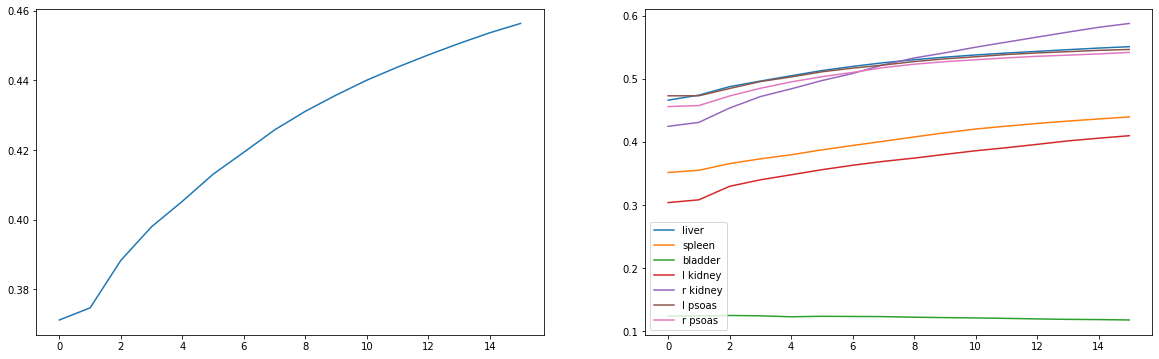

In [96]:
# try to use the fine_tuned MIND network...
with torch.no_grad():
    dev_nr = 0
    reg_iter = 15#5
    lambda_reg = 10#50#25
    sc_val = 1.0
    solver_iter = 3
    C_out = 12#8
    
    dice_evo_net_tune = torch.zeros(nr_test_pairs,reg_iter+1,7)
    
    for tpdx in range(nr_test_pairs):
        print((tpdx+1).__str__()+' / '+nr_test_pairs.__str__())
        # decoupled dimensions
        with torch.cuda.device(dev_nr):
            
            tune_MIND = tune_MIND.cuda().eval()
            
            #img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[tpdx].item(), mr_test_pats[tpdx].item(), 0.55)#0.65
            img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[rnd_ct_test[tpdx]].item(), mr_test_pats[rnd_mr_test[tpdx]].item(), 0.70)
            dice_evo_net_tune[tpdx,0,:] = dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8)
            
            # get output dimensions!
            test_in = torch.ones(1,1,D,H,W).cuda()
            test_out = tune_MIND(test_in,'ct')
            #test_out = back_net(test_in,0.25)
            _,_,Ds,Hs,Ws = test_out.size()

            L = laplace(lambda_reg,Ds,Hs,Ws).cuda()
            L_u = laplace_block(lambda_reg,Ds,Hs,Ws,'u').cuda()
            L_m = laplace_block(lambda_reg,Ds,Hs,Ws,'m').cuda()
            L_l = laplace_block(lambda_reg,Ds,Hs,Ws,'l').cuda()

            u_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
            v_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
            w_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()

            id_grid = torch.nn.functional.affine_grid(torch.eye(3,4).view(1,3,4),(1,1,D,H,W)).cuda()

            avg3d = torch.nn.AvgPool3d(kernel_size=5,padding=2,stride=1)


            for idx in range(reg_iter):

                # upscale displacement fields
                with torch.no_grad():
                    grid_up_km1 = torch.cat((w_km1.view(1,Ds,Hs,Ws,1),v_km1.view(1,Ds,Hs,Ws,1),u_km1.view(1,Ds,Hs,Ws,1)),4)
                    grid_up_km1 = avg3d(grid_up_km1.permute(0,4,1,2,3))
                    grid_up_km1 = torch.nn.functional.interpolate(grid_up_km1, size=(D,H,W)).permute(0,2,3,4,1)

                    M_km1_full = torch.nn.functional.grid_sample(img_mov_t.view(1,1,D,H,W).cuda(), 
                                                                 grid_up_km1 + id_grid,
                                                                 padding_mode='border')


                # generate feature representation
                M_km1 = tune_MIND(M_km1_full.detach(),'ct')
                fix = tune_MIND(img_fix_t.cuda().detach(),'mr')

                #M_km1 = back_net(M_km1_full.detach(),0.25)
                #fix = back_net(img_fix.cuda().detach(),0.25)
                
                M_km1_dD = d_dD(M_km1)
                M_km1_dH = d_dH(M_km1)
                M_km1_dW = d_dW(M_km1)

                RHS_D = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dD.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,u_km1.view(Ds*Hs*Ws,1))
                RHS_H = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dH.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,v_km1.view(Ds*Hs*Ws,1))
                RHS_W = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dW.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,w_km1.view(Ds*Hs*Ws,1))

                MAT = torch.sparse.FloatTensor(3*Ds*Hs*Ws,3*Ds*Hs*Ws).cuda()

                M1_DD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dD**2).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                M1_DH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dD*M_km1_dH).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                M1_DW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dD*M_km1_dW).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()

                M1_HH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dH**2).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                M1_HD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dH*M_km1_dD).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                M1_HW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dH*M_km1_dW).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()

                M1_WW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dW**2).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                M1_WD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dW*M_km1_dD).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                M1_WH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                 (M_km1_dW*M_km1_dH).sum(1).view(-1),
                                                 torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()


                MAT = MAT.add(M1_DD).add(L_u)
                MAT = MAT.add(M1_DH)
                MAT = MAT.add(M1_DW)

                MAT = MAT.add(M1_HD)
                MAT = MAT.add(M1_HH).add(L_m)
                MAT = MAT.add(M1_HW)

                MAT = MAT.add(M1_WD)
                MAT = MAT.add(M1_WH)
                MAT = MAT.add(M1_WW).add(L_l)

                RHS = torch.cat((RHS_D, RHS_H, RHS_W),0)

                wvu = mlg_solver(MAT,RHS,3)

                w_k = wvu[2*Ds*Hs*Ws:]*(2.0/(Ws-1.0)) 
                v_k = wvu[Ds*Hs*Ws:2*Ds*Hs*Ws]*(2.0/(Hs-1.0))
                u_k = wvu[:Ds*Hs*Ws]*(2.0/(Ds-1.0))

                u_km1_crnt = u_km1 + u_k#*0.05#25
                v_km1_crnt = v_km1 + v_k#*0.05#25
                w_km1_crnt = w_km1 + w_k#*0.05#25

                grid_km1_tmp = torch.cat((w_km1_crnt.view(1,1,Ds,Hs,Ws),
                                          v_km1_crnt.view(1,1,Ds,Hs,Ws),
                                          u_km1_crnt.view(1,1,Ds,Hs,Ws)),1)
                grid_km1_tmp = avg3d(grid_km1_tmp)
                grid_km1_tmp = torch.nn.functional.interpolate(grid_km1_tmp, size=(D,H,W),
                                                               mode='trilinear').permute(0,2,3,4,1)

                u_km1 = u_km1_crnt.clone().detach()
                v_km1 = v_km1_crnt.clone().detach()
                w_km1 = w_km1_crnt.clone().detach()

                seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                               grid_km1_tmp + id_grid,
                                                               mode='nearest',
                                                               padding_mode='border')
                dice_evo_net_tune[tpdx,idx+1,:] = dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8)

    plt.figure(figsize=(20,6))
    plt.subplot(121)
    plt.plot(dice_evo_net_tune.mean(0).mean(1).cpu().numpy())
    plt.subplot(122)
    plt.plot(dice_evo_net_tune.mean(0).cpu().numpy())
    plt.legend(labels=["liver","spleen","bladder","l kidney","r kidney", "l psoas", "r psoas"])

before:  tensor([0.6758, 0.6241, 0.0000, 0.6948, 0.7423, 0.5189, 0.5185]) tensor(0.5392)
after:  tensor([0.7215, 0.5889, 0.0000, 0.8280, 0.8375, 0.5458, 0.4925]) tensor(0.5735)
torch.Size([1, 12, 65, 48, 67])


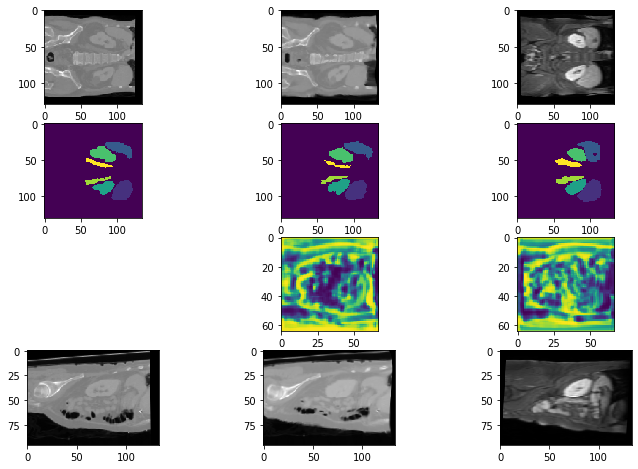

In [97]:
with torch.no_grad():
    seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                   grid_km1_tmp + id_grid,
                                                   mode='nearest',
                                                   padding_mode='border')
    
    print('before: ',dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8),dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8).mean())
    print('after: ',dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8),dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8).mean())
    
    
    img_mov_warp = torch.nn.functional.grid_sample(img_mov_t.cuda(), 
                                                   grid_km1_tmp + id_grid,
                                                   #mode='bilinear',
                                                   padding_mode='border')
    
    print(fix.size())
    
    plt.figure(figsize=(12,8))
    plt_sl = 35
    plt_slice = 30
    plt_chan = 8
    plt.subplot(4,3,1)
    plt.imshow(img_mov_t.cpu()[0,0,:,plt_sl,:],'gray')
    plt.subplot(4,3,2)
    plt.imshow(img_mov_warp.cpu()[0,0,:,plt_sl,:],'gray')
    plt.subplot(4,3,3)
    plt.imshow(img_fix_t.cpu()[0,0,:,plt_sl,:],'gray')
    plt.subplot(4,3,4)
    plt.imshow(seg_mov_t.cpu()[0,0,:,plt_sl,:])
    plt.subplot(4,3,5)
    plt.imshow(seg_mov_warp.cpu()[0,0,:,plt_sl,:])
    plt.subplot(4,3,6)
    plt.imshow(seg_fix_t.cpu()[0,0,:,plt_sl,:])
    plt.subplot(4,3,8)
    plt.imshow(M_km1.cpu()[0,plt_chan,:,plt_slice,:])
    plt.subplot(4,3,9)
    plt.imshow(fix.cpu()[0,plt_chan,:,plt_slice,:])
    plt.subplot(4,3,10)
    plt.imshow(img_mov_t.cpu()[0,0,40,:,:],'gray')
    plt.subplot(4,3,11)
    plt.imshow(img_mov_warp.cpu()[0,0,40,:,:],'gray')
    plt.subplot(4,3,12)
    plt.imshow(img_fix_t.cpu()[0,0,40,:,:],'gray')

1 / 25
CT Pat:  2  :: MR Pat:  1
2 / 25
CT Pat:  17  :: MR Pat:  19
3 / 25
CT Pat:  13  :: MR Pat:  1
4 / 25
CT Pat:  17  :: MR Pat:  1
5 / 25
CT Pat:  19  :: MR Pat:  1
6 / 25
CT Pat:  12  :: MR Pat:  14
7 / 25
CT Pat:  12  :: MR Pat:  6
8 / 25
CT Pat:  13  :: MR Pat:  14
9 / 25
CT Pat:  12  :: MR Pat:  15
10 / 25
CT Pat:  19  :: MR Pat:  12
11 / 25
CT Pat:  12  :: MR Pat:  12
12 / 25
CT Pat:  12  :: MR Pat:  1
13 / 25
CT Pat:  3  :: MR Pat:  14
14 / 25
CT Pat:  2  :: MR Pat:  12
15 / 25
CT Pat:  3  :: MR Pat:  6
16 / 25
CT Pat:  13  :: MR Pat:  12
17 / 25
CT Pat:  13  :: MR Pat:  15
18 / 25
CT Pat:  13  :: MR Pat:  6
19 / 25
CT Pat:  19  :: MR Pat:  14
20 / 25
CT Pat:  3  :: MR Pat:  15
21 / 25
CT Pat:  2  :: MR Pat:  14
22 / 25
CT Pat:  13  :: MR Pat:  19
23 / 25
CT Pat:  2  :: MR Pat:  19
24 / 25
CT Pat:  17  :: MR Pat:  6
25 / 25
CT Pat:  3  :: MR Pat:  12


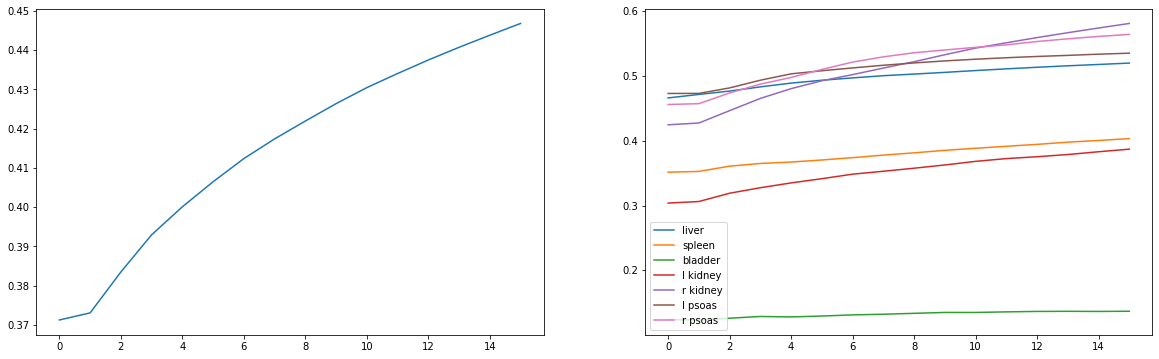

In [98]:
# try to use MIND...
with torch.no_grad():
    dev_nr = 0
    reg_iter = 15#10
    lambda_reg = 10#2.5#25
    solver_iter = 3
    C_out = 12
    sc_val = 0.70
    sub_sc_val = 0.5
    dice_evo_mind = torch.zeros(nr_test_pairs,reg_iter+1,7)
    
    if flag_all:
        for tpdx in range(nr_test_pairs):
            print((tpdx+1).__str__()+' / '+nr_test_pairs.__str__())
            # decoupled dimensions
            with torch.cuda.device(dev_nr):
                #img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[tpdx].item(), mr_test_pats[tpdx].item(), sc_val)
                img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[rnd_ct_test[tpdx]].item(), mr_test_pats[rnd_mr_test[tpdx]].item(), 0.70)
                dice_evo_mind[tpdx,0,:] = dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8)
                _,_,Ds,Hs,Ws = torch.nn.functional.interpolate(img_fix_t,scale_factor=sub_sc_val,mode='trilinear').size()

                L = laplace(lambda_reg,Ds,Hs,Ws).cuda()
                L_u = laplace_block(lambda_reg,Ds,Hs,Ws,'u').cuda()
                L_m = laplace_block(lambda_reg,Ds,Hs,Ws,'m').cuda()
                L_l = laplace_block(lambda_reg,Ds,Hs,Ws,'l').cuda()

                u_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
                v_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()
                w_km1 = torch.zeros(Ds*Hs*Ws).view(-1,1).cuda()

                id_grid = torch.nn.functional.affine_grid(torch.eye(3,4).view(1,3,4),(1,1,D,H,W)).cuda()

                avg3d = torch.nn.AvgPool3d(kernel_size=5,padding=2,stride=1)


                for idx in range(reg_iter):

                    # upscale displacement fields
                    with torch.no_grad():
                        grid_up_km1 = torch.cat((w_km1.view(1,Ds,Hs,Ws,1),v_km1.view(1,Ds,Hs,Ws,1),u_km1.view(1,Ds,Hs,Ws,1)),4)
                        grid_up_km1 = avg3d(grid_up_km1.permute(0,4,1,2,3))
                        #grid_up_km1 = grid_up_km1.permute(0,4,1,2,3)
                        grid_up_km1 = torch.nn.functional.interpolate(grid_up_km1, size=(D,H,W)).permute(0,2,3,4,1)

                        M_km1_full = torch.nn.functional.grid_sample(img_mov_t.view(1,1,D,H,W).cuda(), 
                                                                     grid_up_km1 + id_grid,
                                                                     padding_mode='border')


                    # generate feature representation
                    M_km1 = MINDSSC3d(M_km1_full.detach())#,dil=2,patch_rad=2)
                    fix = MINDSSC3d(img_fix_t.cuda().detach())#,dil=2,patch_rad=2)

                    # subsample
                    M_km1 = torch.nn.functional.interpolate(M_km1,scale_factor=sub_sc_val,mode='trilinear')
                    fix = torch.nn.functional.interpolate(fix,scale_factor=sub_sc_val,mode='trilinear')

                    M_km1_dD = d_dD(M_km1)
                    M_km1_dH = d_dH(M_km1)
                    M_km1_dW = d_dW(M_km1)

                    RHS_D = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dD.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,u_km1.view(Ds*Hs*Ws,1))
                    RHS_H = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dH.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,v_km1.view(Ds*Hs*Ws,1))
                    RHS_W = -((M_km1-fix).view(C_out,Ds*Hs*Ws,1)*M_km1_dW.view(C_out,Ds*Hs*Ws,1)).sum(0) - torch.spmm(L,w_km1.view(Ds*Hs*Ws,1))

                    MAT = torch.sparse.FloatTensor(3*Ds*Hs*Ws,3*Ds*Hs*Ws).cuda()

                    M1_DD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dD**2).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_DH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dD*M_km1_dH).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_DW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dD*M_km1_dW).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()

                    M1_HH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dH**2).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_HD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dH*M_km1_dD).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_HW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dH*M_km1_dW).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()

                    M1_WW = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dW**2).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_WD = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dW*M_km1_dD).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()
                    M1_WH = torch.sparse.FloatTensor(torch.stack((torch.arange(Ds*Hs*Ws)+2*(Ds*Hs*Ws),torch.arange(Ds*Hs*Ws)+(Ds*Hs*Ws)),0).cuda(),
                                                     (M_km1_dW*M_km1_dH).sum(1).view(-1),
                                                     torch.Size([3*Ds*Hs*Ws,3*Ds*Hs*Ws])).detach()


                    MAT = MAT.add(M1_DD).add(L_u)
                    MAT = MAT.add(M1_DH)
                    MAT = MAT.add(M1_DW)

                    MAT = MAT.add(M1_HD)
                    MAT = MAT.add(M1_HH).add(L_m)
                    MAT = MAT.add(M1_HW)

                    MAT = MAT.add(M1_WD)
                    MAT = MAT.add(M1_WH)
                    MAT = MAT.add(M1_WW).add(L_l)

                    RHS = torch.cat((RHS_D, RHS_H, RHS_W),0)

                    wvu = mlg_solver(MAT,RHS,3)

                    w_k = wvu[2*Ds*Hs*Ws:]*(2.0/(Ws-1.0)) 
                    v_k = wvu[Ds*Hs*Ws:2*Ds*Hs*Ws]*(2.0/(Hs-1.0))
                    u_k = wvu[:Ds*Hs*Ws]*(2.0/(Ds-1.0))

                    u_km1_crnt = u_km1 + u_k#*0.25#25
                    v_km1_crnt = v_km1 + v_k#*0.25#25
                    w_km1_crnt = w_km1 + w_k#*0.25#25

                    grid_km1_tmp = torch.cat((w_km1_crnt.view(1,1,Ds,Hs,Ws),
                                              v_km1_crnt.view(1,1,Ds,Hs,Ws),
                                              u_km1_crnt.view(1,1,Ds,Hs,Ws)),1)
                    grid_km1_tmp = avg3d(grid_km1_tmp)
                    grid_km1_tmp = torch.nn.functional.interpolate(grid_km1_tmp, size=(D,H,W),
                                                                   mode='trilinear').permute(0,2,3,4,1)

                    u_km1 = u_km1_crnt.clone().detach()
                    v_km1 = v_km1_crnt.clone().detach()
                    w_km1 = w_km1_crnt.clone().detach()

                    seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                           grid_km1_tmp + id_grid,
                                                           mode='nearest',
                                                           padding_mode='border')
                    dice_evo_mind[tpdx,idx+1,:] = dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8)


    plt.figure(figsize=(20,6))
    plt.subplot(121)
    plt.plot(dice_evo_mind.mean(2).mean(0).cpu().numpy())
    plt.subplot(122)
    plt.plot(dice_evo_mind.mean(0).cpu().numpy())
    plt.legend(labels=["liver","spleen","bladder","l kidney","r kidney", "l psoas", "r psoas"])

before:  tensor([0.6758, 0.6241, 0.0000, 0.6948, 0.7423, 0.5189, 0.5185]) tensor(0.5392)
after:  tensor([0.7103, 0.5911, 0.0067, 0.8317, 0.8354, 0.5209, 0.4925]) tensor(0.5698)


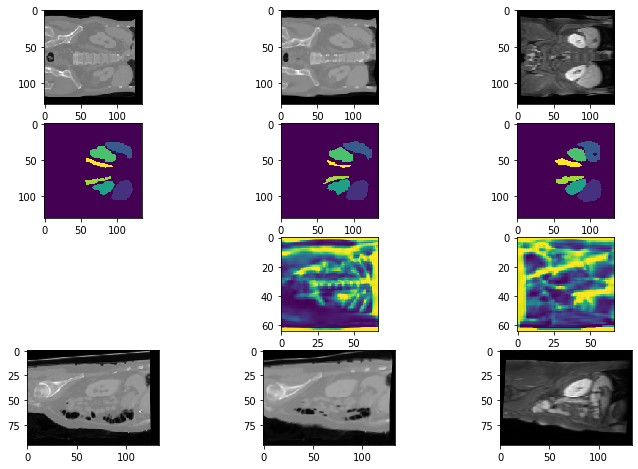

In [99]:
with torch.no_grad():
    if flag_all:
        seg_mov_warp = torch.nn.functional.grid_sample(seg_mov_t.cuda(), 
                                                       grid_km1_tmp + id_grid,
                                                       mode='nearest',
                                                       padding_mode='border')

        print('before: ',dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8),dice_coeff(seg_mov_t.cpu(),seg_fix_t,max_label=8).mean())
        print('after: ',dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8),dice_coeff(seg_mov_warp.cpu(),seg_fix_t,max_label=8).mean())


        img_mov_warp = torch.nn.functional.grid_sample(img_mov_t.cuda(), 
                                                       grid_km1_tmp + id_grid,
                                                       #mode='bilinear',
                                                       padding_mode='border')

        plt.figure(figsize=(12,8))
        plt_sl = 35
        plt_slice = 10
        plt_chan = 2
        plt.subplot(4,3,1)
        plt.imshow(img_mov_t.cpu()[0,0,:,plt_sl,:],'gray')
        plt.subplot(4,3,2)
        plt.imshow(img_mov_warp.cpu()[0,0,:,plt_sl,:],'gray')
        plt.subplot(4,3,3)
        plt.imshow(img_fix_t.cpu()[0,0,:,plt_sl,:],'gray')
        plt.subplot(4,3,4)
        plt.imshow(seg_mov_t.cpu()[0,0,:,plt_sl,:])
        plt.subplot(4,3,5)
        plt.imshow(seg_mov_warp.cpu()[0,0,:,plt_sl,:])
        plt.subplot(4,3,6)
        plt.imshow(seg_fix_t.cpu()[0,0,:,plt_sl,:])
        plt.subplot(4,3,8)
        plt.imshow(M_km1.cpu()[0,plt_chan,:,plt_slice,:])
        plt.subplot(4,3,9)
        plt.imshow(fix.cpu()[0,plt_chan,:,plt_slice,:])
        plt.subplot(4,3,10)
        plt.imshow(img_mov_t.cpu()[0,0,40,:,:],'gray')
        plt.subplot(4,3,11)
        plt.imshow(img_mov_warp.cpu()[0,0,40,:,:],'gray')
        plt.subplot(4,3,12)
        plt.imshow(img_fix_t.cpu()[0,0,40,:,:],'gray')

In [100]:
import SimpleITK as sitk

In [ ]:
cnt = 0

dice_elastix = torch.zeros(nr_test_pairs,7)
dice_init = torch.zeros(nr_test_pairs,7)

if flag_all:

    for idx in range(nr_test_pairs):

        #img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[idx].item(), mr_test_pats[idx].item(), 1.0)
        img_fix_t, seg_fix_t, img_mov_t, seg_mov_t = get_ct_mr_pair(ct_test_pats[rnd_ct_test[idx]].item(), mr_test_pats[rnd_mr_test[idx]].item(), 1.0)
        npa_fix = img_fix_t.squeeze().numpy()
        npa_mov = img_mov_t.squeeze().numpy()

        elastixImageFilter = sitk.ElastixImageFilter()
        elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(npa_fix))
        elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(npa_mov))

        parameterMapVector = sitk.VectorOfParameterMap()
        #parameterMapVector.append(sitk.GetDefaultParameterMap("translation"))
        pmap = sitk.GetDefaultParameterMap("bspline")
        pmap['MaximumNumberOfIterations'] = ['64']
        pmap['FinalGridSpacingInPhysicalUnits'] = ['4']
        parameterMapVector.append(pmap)
        elastixImageFilter.SetParameterMap(parameterMapVector)

        #elastixImageFilter.PrintParameterMap()    

        elastixImageFilter.Execute()
        res = elastixImageFilter.GetResultImage()

        # warp label accordingly
        npa_fix_label = seg_fix_t.squeeze().numpy()
        npa_mov_label = seg_mov_t.squeeze().numpy()

        tp = elastixImageFilter.GetTransformParameterMap()

        tp[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
        ##tp[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]

        #tp[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
        #tp[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
        #tp[2]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]

        resultLabel = sitk.Transformix(sitk.GetImageFromArray(npa_mov_label), tp)
        out_npa_label = sitk.GetArrayViewFromImage(resultLabel)

        dice_init[cnt,:] = dice_coeff(torch.from_numpy(npa_mov_label),torch.from_numpy(npa_fix_label),8)
        dice_elastix[cnt,:] = dice_coeff(torch.from_numpy(out_npa_label),torch.from_numpy(npa_fix_label),8)
        cnt += 1
        
print('Init:', dice_init.mean())
print('Elastix:', dice_elastix.mean())

CT Pat:  2  :: MR Pat:  1
CT Pat:  17  :: MR Pat:  19
CT Pat:  13  :: MR Pat:  1
CT Pat:  17  :: MR Pat:  1
CT Pat:  19  :: MR Pat:  1
CT Pat:  12  :: MR Pat:  14
CT Pat:  12  :: MR Pat:  6
CT Pat:  13  :: MR Pat:  14
CT Pat:  12  :: MR Pat:  15
CT Pat:  19  :: MR Pat:  12
CT Pat:  12  :: MR Pat:  12
CT Pat:  12  :: MR Pat:  1
CT Pat:  3  :: MR Pat:  14
CT Pat:  2  :: MR Pat:  12
CT Pat:  3  :: MR Pat:  6
CT Pat:  13  :: MR Pat:  12
CT Pat:  13  :: MR Pat:  15
CT Pat:  13  :: MR Pat:  6
CT Pat:  19  :: MR Pat:  14
CT Pat:  3  :: MR Pat:  15
CT Pat:  2  :: MR Pat:  14
CT Pat:  13  :: MR Pat:  19
CT Pat:  2  :: MR Pat:  19
CT Pat:  17  :: MR Pat:  6
CT Pat:  3  :: MR Pat:  12


In [ ]:
print(dice_elastix.mean().mean())
print(dice_init)
print(dice_elastix)

if flag_all:

    #tp[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    ##tp[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]

    tp[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    #tp[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    #tp[2]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]

    resultLabel = sitk.Transformix(sitk.GetImageFromArray(npa_mov_label), tp)
    out_npa_label = sitk.GetArrayViewFromImage(resultLabel)

    plt.figure(figsize=(15,8))
    plt.subplot(331)
    plt.imshow(npa_mov_label[80,:,:])
    plt.colorbar()
    plt.subplot(332)
    plt.imshow(out_npa_label[80,:,:])
    plt.colorbar()
    plt.subplot(333)
    plt.imshow(npa_fix_label[80,:,:])
    plt.colorbar()
    plt.subplot(334)
    plt.imshow(npa_mov_label[:,50,:])
    plt.subplot(335)
    plt.imshow(out_npa_label[:,50,:])
    plt.subplot(336)
    plt.imshow(npa_fix_label[:,50,:])
    plt.subplot(337)
    plt.imshow(npa_mov_label[:,:,50])
    plt.subplot(338)
    plt.imshow(out_npa_label[:,:,50])
    plt.subplot(339)
    plt.imshow(npa_fix_label[:,:,50])

In [ ]:
print('INIT')
#print(dice_init)
print(dice_init.mean(1))
print(dice_init.mean(1).mean())
print(' ')
print('NET_pre')
#print(dice_evo_net_pre[:,-1,:])
print(dice_evo_net_pre[:,-1,:].mean(1))
print(dice_evo_net_pre[:,-1,:].mean(1).mean())
print(' ')
print('NET_tune')
#print(dice_evo_net_tune[:,-1,:])
print(dice_evo_net_tune[:,-1,:].mean(1))
print(dice_evo_net_tune[:,-1,:].mean(1).mean())
print(' ')
print('MIND')
#print(dice_evo_mind[:,-1,:])
print(dice_evo_mind[:,-1,:].mean(1))
print(dice_evo_mind[:,-1,:].mean(1).mean())
print(' ')
print('Elastix')
#print(dice_elastix)
print(dice_elastix.mean(1))
print(dice_elastix.mean(1).mean())

In [ ]:
# without bladder!

print('INIT')
#print(dice_init)
print(dice_init[:,torch.LongTensor([0,1,2,4,5,6])].mean(1))
print(dice_init[:,torch.LongTensor([0,1,2,4,5,6])].mean(1).mean())
print(' ')
print('NET_pre')
#print(dice_evo_net_pre[:,-1,:])
print(dice_evo_net_pre[:,-1,torch.LongTensor([0,1,2,4,5,6])].mean(1))
print(dice_evo_net_pre[:,-1,torch.LongTensor([0,1,2,4,5,6])].mean(1).mean())
print(' ')
print('NET_tune')
#print(dice_evo_net_tune[:,-1,:])
print(dice_evo_net_tune[:,-1,torch.LongTensor([0,1,2,4,5,6])].mean(1))
print(dice_evo_net_tune[:,-1,torch.LongTensor([0,1,2,4,5,6])].mean(1).mean())
print(' ')
print('MIND')
#print(dice_evo_mind[:,-1,:])
print(dice_evo_mind[:,-1,torch.LongTensor([0,1,2,4,5,6])].mean(1))
print(dice_evo_mind[:,-1,torch.LongTensor([0,1,2,4,5,6])].mean(1).mean())
print(' ')
print('Elastix')
#print(dice_elastix)
print(dice_elastix[:,torch.LongTensor([0,1,2,4,5,6])].mean(1))
print(dice_elastix[:,torch.LongTensor([0,1,2,4,5,6])].mean(1).mean())

In [ ]:
import os, datetime
base_dir = os.getcwd()
dir_timestamp = '/exp_70_'+datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
mydir = base_dir + dir_timestamp
os.makedirs(mydir)

cpy_notebook_cmd = 'cp ./3d_coupled_CTMR_UnbiasedData_UsePretrainedMIND_70-15steps_2layer.ipynb '+mydir+'/3d_coupled_CTMR_UnbiasedData_UsePretrainedMIND_70-15steps_2layer.ipynb'
! $cpy_notebook_cmd
cpy_notebook_cmd = 'cp ./mind_pretrained_net_70_2layer.pth '+mydir+'/mind_pretrained_net_70_2layer.pth'
! $cpy_notebook_cmd
cpy_notebook_cmd = 'cp ./mind_tuned_net_70_2layer.pth '+mydir+'/mind_tuned_net_70_2layer.pth'
! $cpy_notebook_cmd

In [ ]:
torch.save(dice_init, mydir+'/dice_init.pth')
torch.save(dice_evo_net_pre, mydir+'/dice_evo_net_pre.pth')
torch.save(dice_evo_net_tune, mydir+'/dice_evo_net_tune.pth')
torch.save(dice_evo_mind, mydir+'/dice_evo_mind.pth')
torch.save(dice_elastix, mydir+'/dice_elastix.pth')

In [ ]:
print(dice_init.size())
print(dice_evo_net_tune.size())
print(dice_evo_net_pre.size())
print(dice_evo_mind.size())
print(dice_elastix.size())

np.savetxt( mydir+'/dice_init.txt', dice_init.numpy(), delimiter='\t', fmt='%5f')
np.savetxt( mydir+'/dice_net_pre.txt', dice_evo_net_pre[:,-1,:].numpy(), delimiter='\t', fmt='%5f')
np.savetxt( mydir+'/dice_net_tune.txt', dice_evo_net_tune[:,-1,:].numpy(), delimiter='\t', fmt='%5f')
np.savetxt( mydir+'/dice_mind.txt', dice_evo_mind[:,-1,:].numpy(), delimiter='\t', fmt='%5f')
np.savetxt( mydir+'/dice_elastix.txt', dice_elastix.numpy(), delimiter='\t', fmt='%5f')

In [ ]:
print(dice_init)